# Project Title Here

**Names**: Sarah Yang, Congfei Yin, Justin Wang

You can delete and add as many code blocks as you like or change the formatting.

## 1. Introduction and Dataset Research

For this data analysis we are looking at some pre-cleaned movehub data which gives some measures of cost-of-living in different cities within different countries. The dataset is composed of 2 categorical variables denoting the country and city, and 12 numerical variables which give various measures of the location. Some examples are the price of a cappuccino, the average rent, pollution, and crime rating.

Our research goals is to determine if an unsupervised clustering algorithm can explain the column "movehub_rating" which we discretize and treat as ground-truth labels for the resulting analysis. We also question whether the data itself is clean and without significant outliars. Finally we seek to understand any possible subcluster structure within our discovered clusters.

## 2. Data Cleaning and Data Manipulation

In [1]:
# Some imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

try:
    from tqdm import tqdm
    has_tqdm = True
except:
    has_tqdm = False
    
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans


In [2]:
# Read in data
df = pd.read_csv("movehub_data_cleaned.csv")

In [3]:
df.describe()

Cappuccino      Cinema        Wine    Gasoline     Avg Rent  \
count  185.000000  185.000000  185.000000  185.000000   185.000000   
mean     1.978216    6.461351    7.040703    1.013838  1100.064811   
std      0.762252    2.736618    3.378529    0.349151   676.618422   
min      0.460000    1.810000    2.130000    0.070000   120.680000   
25%      1.310000    4.260000    4.260000    0.780000   618.050000   
50%      2.090000    6.820000    6.340000    0.990000   980.650000   
75%      2.490000    7.970000    8.400000    1.330000  1432.980000   
max      4.480000   14.950000   26.150000    1.680000  5052.310000   

       Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
count             185.000000      185.000000       185.00000   185.000000   
mean             1393.807297       79.612108        45.57973    65.992000   
std               911.383515        6.658616        20.37569    14.943033   
min               120.680000       59.880000         6.38000    20.830000   
25%               527.890000       75.070000        28.82000    58.900000   
50%              1494.670000       80.680000        47.98000    67.590000   
75%              2045.960000       84.080000        60.36000    77.290000   
max              4266.110000      100.000000        91.85000    95.960000   

        Pollution  Quality of Life  Crime Rating  
count  185.000000       185.000000    185.000000  
mean    45.904919        59.038811     41.613135  
std     25.968225        22.153796     16.278047  
min      0.000000         5.290000     10.860000  
25%     23.530000        42.450000     29.530000  
50%     37.210000        62.820000     41.370000  
75%     68.210000        78.060000     51.030000  
max     92.420000        93.050000     85.700000

What we note is that we can treat movehub rating as a label, but unfortunately this is a continuous numerical variable. Instead we choose a 2-group discretization by splitting by the median. We will treat this as our class labels. However we note that any number of discretizations is usable, but with only 185 datapoints, we felt it was prudent to stick to a 2-discretization.

In [4]:
df['discrete_label'] = df['Movehub Rating']
df['discrete_label'][df['Movehub Rating'] < 80.68] = 0
df['discrete_label'][df['Movehub Rating'] >= 80.68] = 1

In [5]:
# Get a numerical dataset for later
df_numerical = df.drop(["City", "Country", "discrete_label"], axis=1)

## 3. Basic Descriptive Analytics

In [6]:
df.head()

City        Country  Cappuccino  Cinema   Wine  Gasoline  Avg Rent  \
0   Lausanne    Switzerland        3.15   12.59   8.40      1.32   1714.00   
1     Geneva    Switzerland        2.80   12.94  10.49      1.28   2607.95   
2      Basel    Switzerland        3.50   11.89   7.35      1.25   1649.29   
3      Perth      Australia        2.87   11.43  10.08      0.97   2083.14   
4  Nashville  United States        3.84   12.00  13.50      0.65   2257.14   

   Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
0                4266.11           87.21           90.77        65.85   
1                3917.72           83.27           61.22        74.88   
2                3847.76           84.20           78.17        79.74   
3                3358.55           95.38           62.11        80.56   
4                3089.75           80.61           80.30        60.30   

   Pollution  Quality of Life  Crime Rating  discrete_label  
0      87.62            73.21         35.55             1.0  
1      29.43            82.76         54.36             1.0  
2      59.18            88.27         28.12             1.0  
3      23.53            74.62         50.01             1.0  
4       0.00            80.50         25.50             0.0

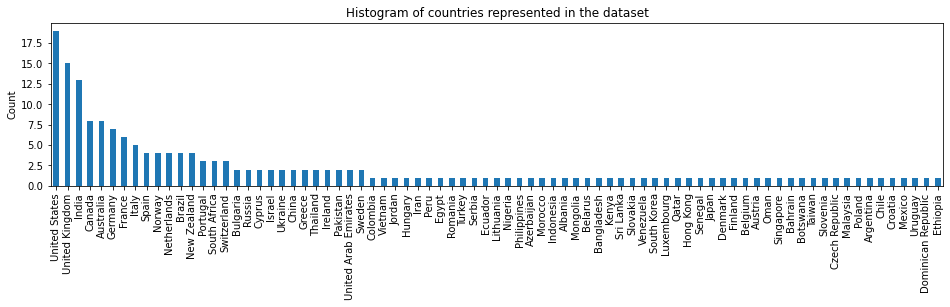

In [7]:
plt.figure(figsize=(16, 3))
ax = df["Country"].value_counts().plot(kind='bar')
_ = plt.title("Histogram of countries represented in the dataset")
_ = plt.ylabel("Count")

*The bias towards developed countries is important and we note that this will eventually result in a trivial cluster forming structure later on.*

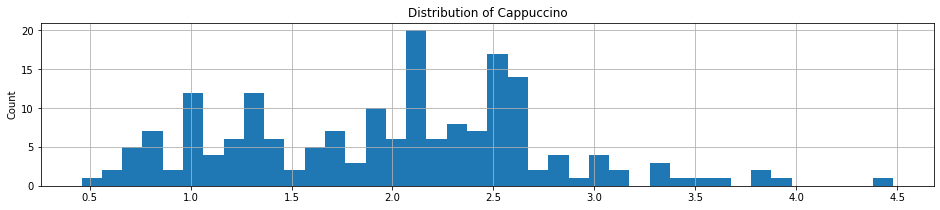

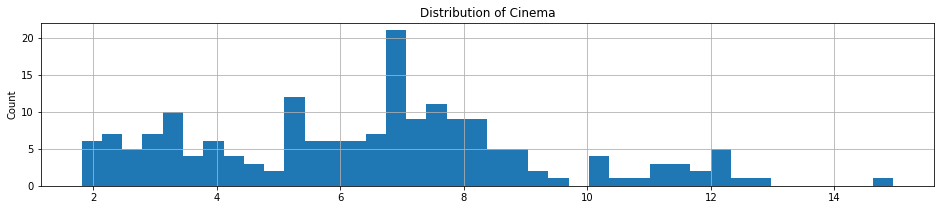

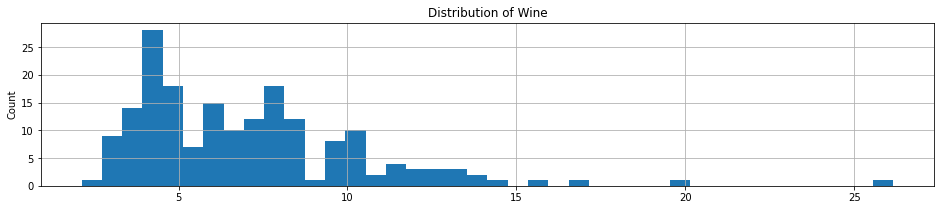

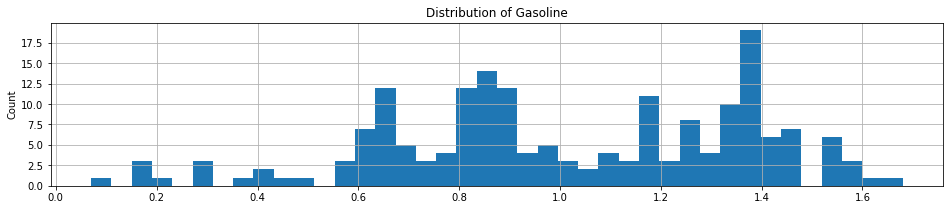

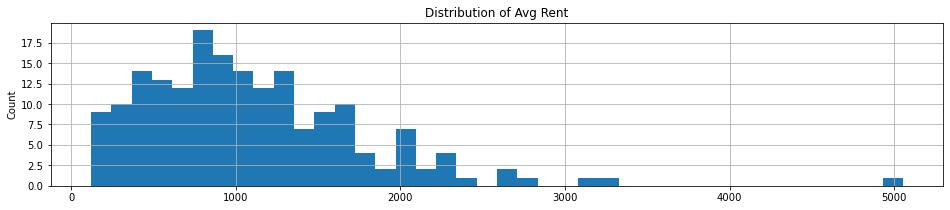

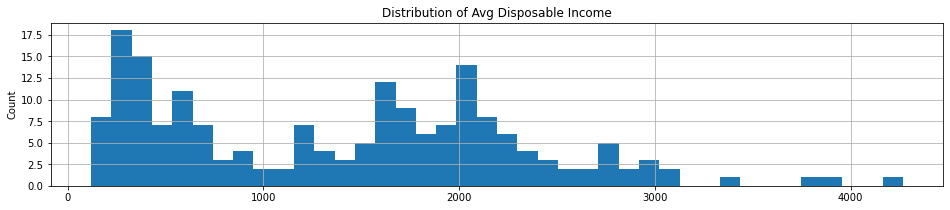

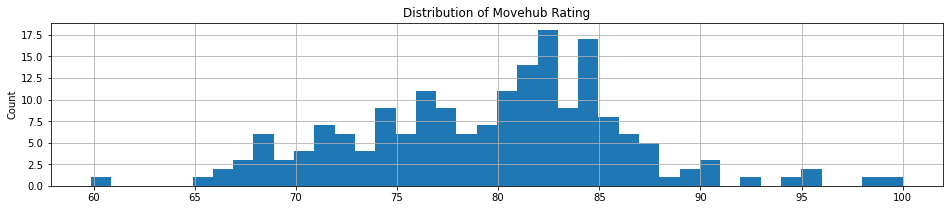

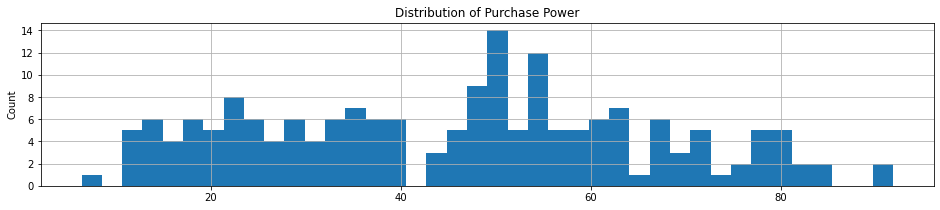

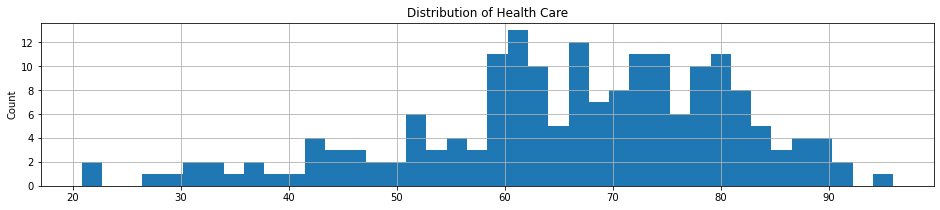

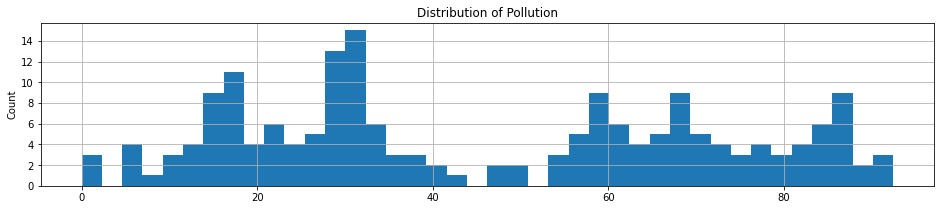

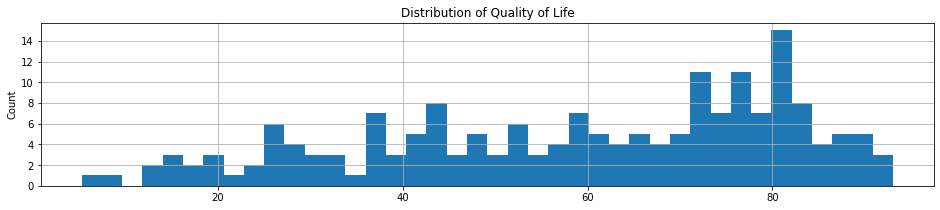

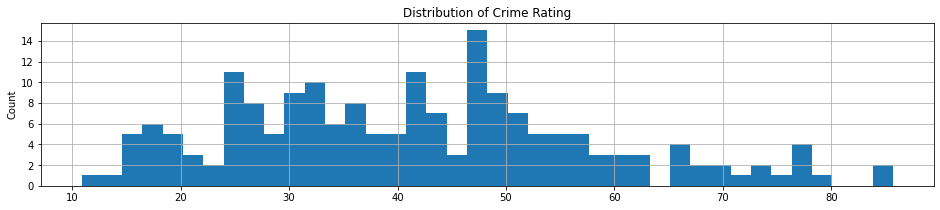

In [8]:
for col in df_numerical.columns:
    plt.figure(figsize=(16, 3))
    df[col].hist(bins=40)
    plt.title("Distribution of " + col)
    plt.ylabel("Count")

We already see some bimodal structures in just the histograms of the numerical variables. Next let's take a look at if there are any obvious pair-wise relationships

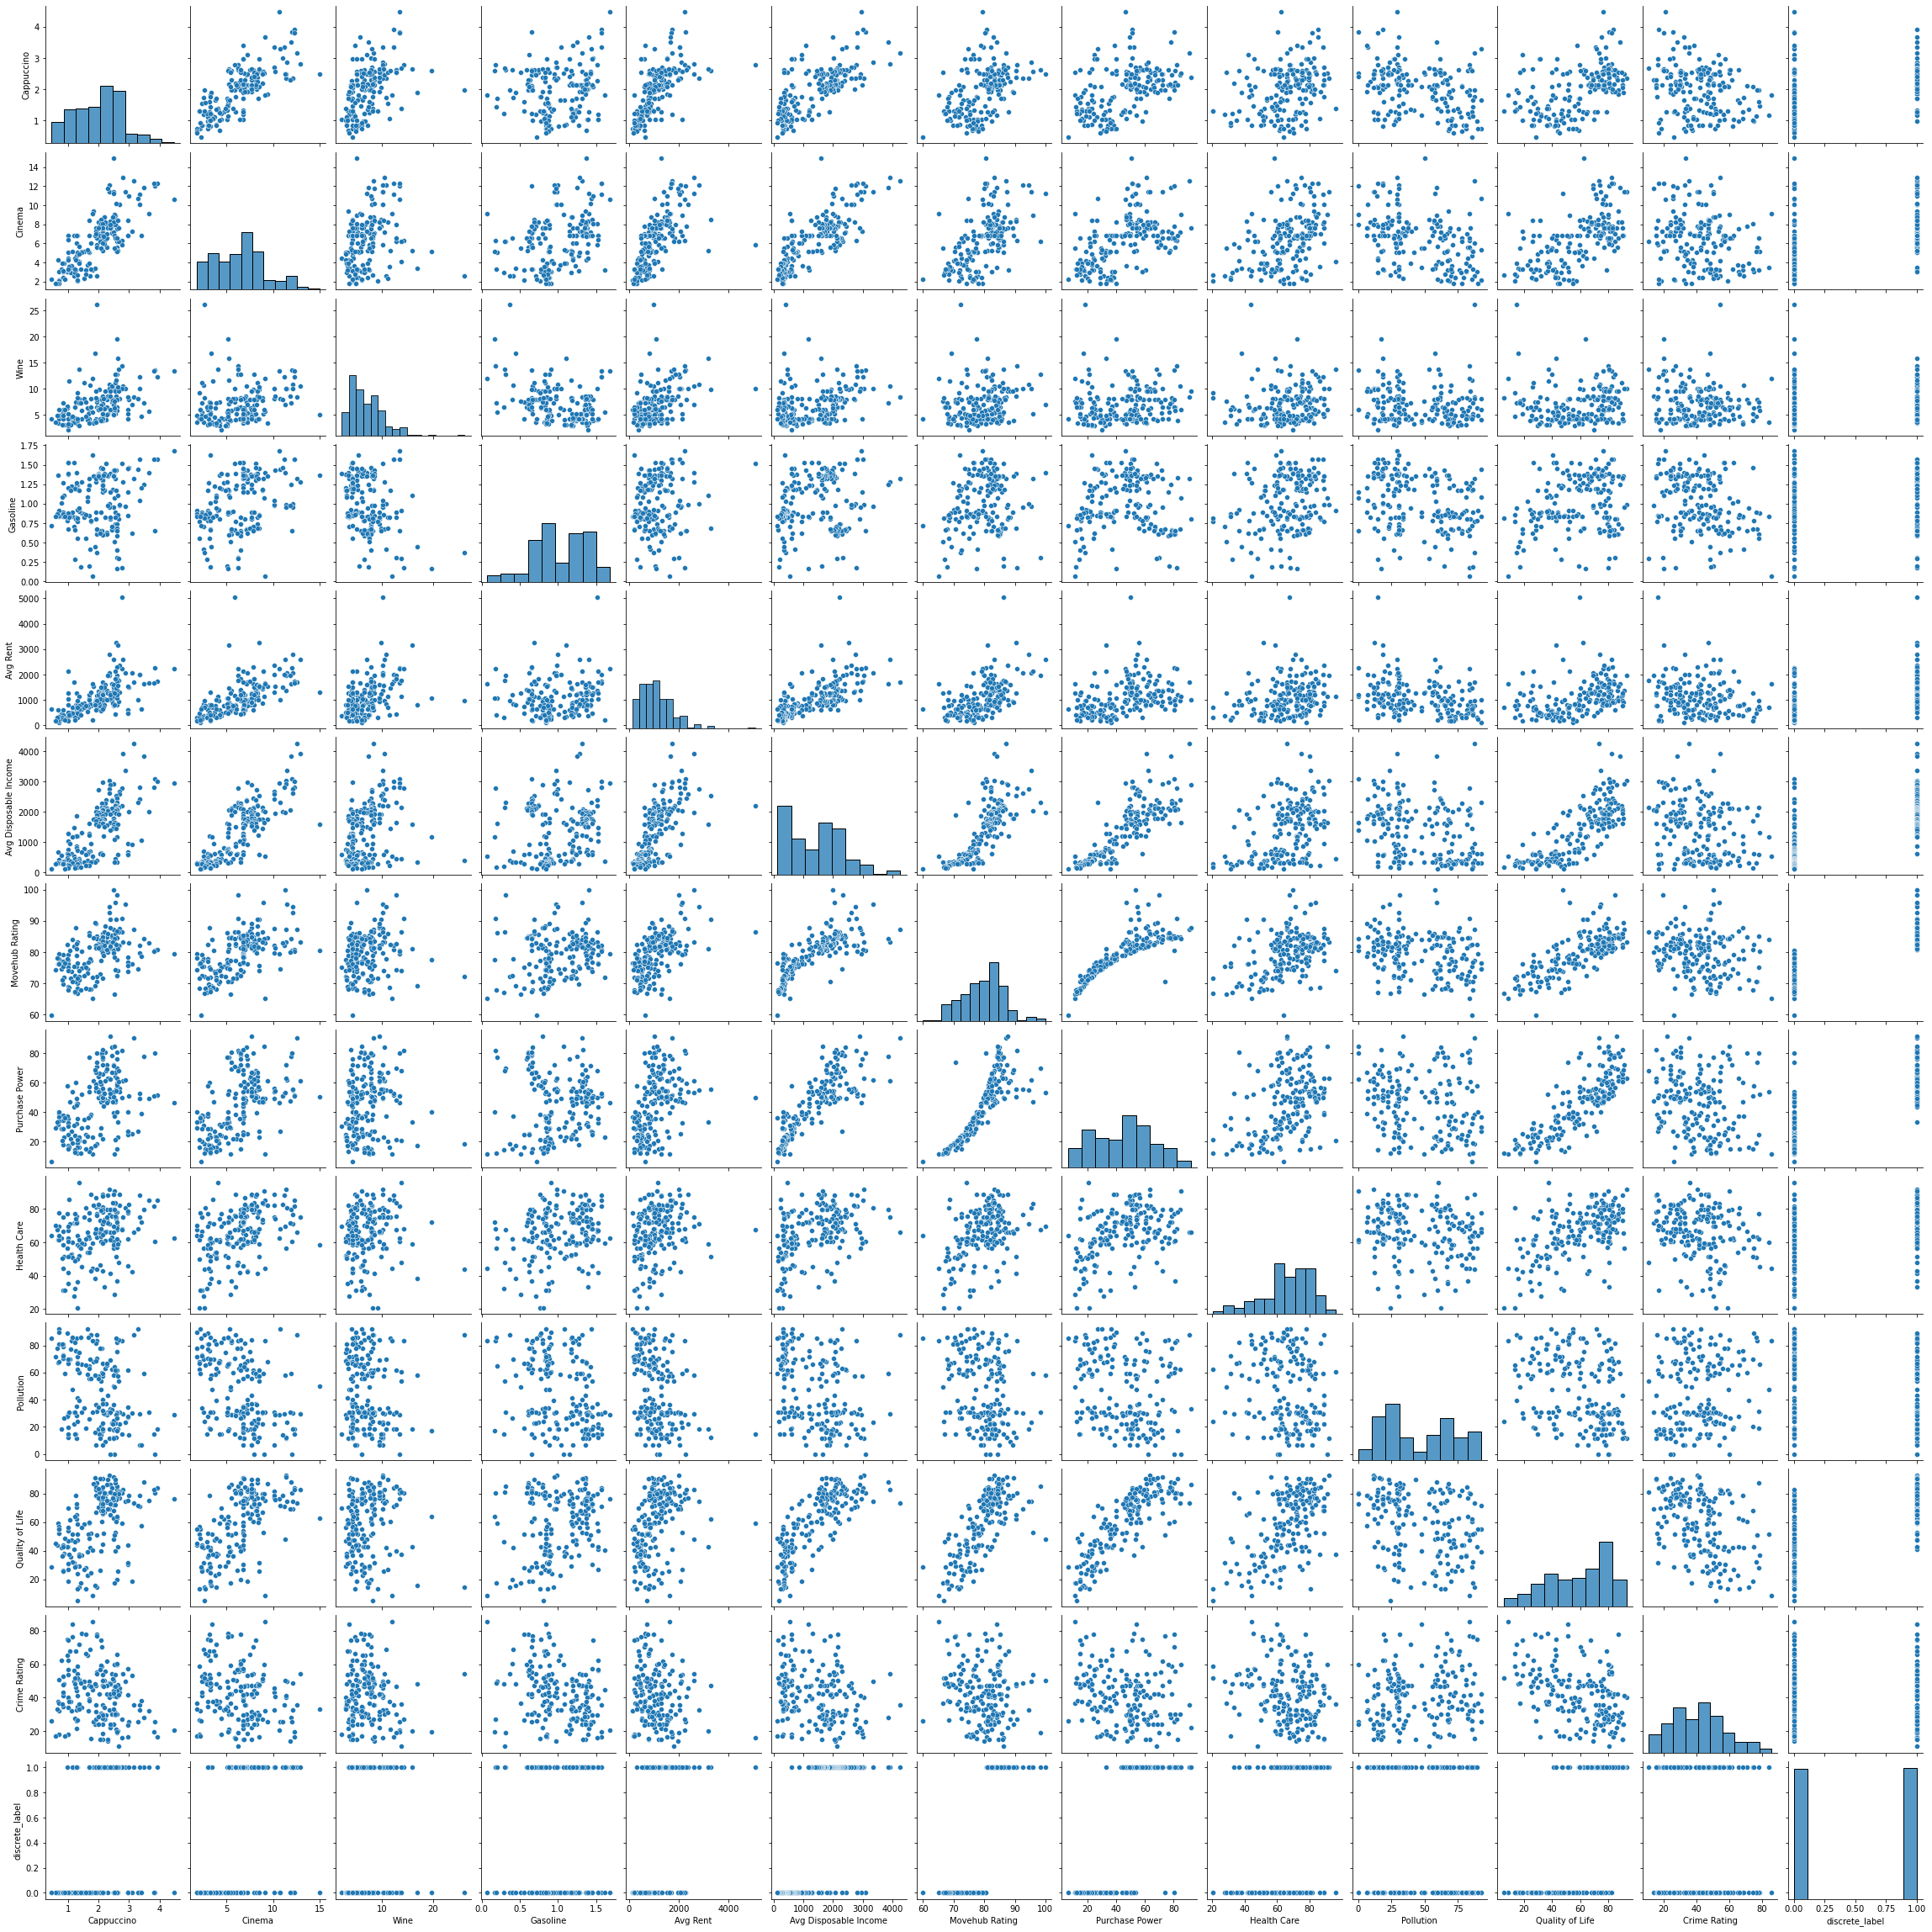

In [9]:
sns.pairplot(df)

There seem to be some structure among the pairplot as well.

## 4. Dataset Scaling Decisions

Let's start by making the Movehub Rating as our label, which we will not scale as it will not be inputted into our algorithms.

In [10]:
df_num = df_numerical.drop(["Movehub Rating"], axis=1)

Lets make a scaled version of our numerical dataset for later use.

In [11]:
sc = StandardScaler()
df_scaled = pd.DataFrame(data=sc.fit_transform(df_num), columns=df_num.columns)
df_scaled.describe()

Cappuccino        Cinema          Wine      Gasoline      Avg Rent  \
count  1.850000e+02  1.850000e+02  1.850000e+02  1.850000e+02  1.850000e+02   
mean   3.792762e-16 -3.840772e-17  4.230850e-17 -6.991404e-17  1.008203e-16   
std    1.002714e+00  1.002714e+00  1.002714e+00  1.002714e+00  1.002714e+00   
min   -1.997157e+00 -1.704284e+00 -1.457448e+00 -2.710573e+00 -1.451398e+00   
25%   -8.790134e-01 -8.065886e-01 -8.252849e-01 -6.715502e-01 -7.143212e-01   
50%    1.470474e-01  1.314111e-01 -2.079616e-01 -6.845901e-02 -1.769666e-01   
75%    6.732324e-01  5.527781e-01  4.034259e-01  9.079744e-01  4.933632e-01   
max    3.291003e+00  3.110293e+00  5.671449e+00  1.913126e+00  5.857024e+00   

       Avg Disposable Income  Purchase Power   Health Care     Pollution  \
count           1.850000e+02    1.850000e+02  1.850000e+02  1.850000e+02   
mean            3.120627e-16    2.709544e-16 -1.704342e-16  1.050211e-16   
std             1.002714e+00    1.002714e+00  1.002714e+00  1.002714e+00   
min            -1.400708e+00   -1.929069e+00 -3.030480e+00 -1.772531e+00   
25%            -9.526913e-01   -8.247677e-01 -4.758904e-01 -8.639650e-01   
50%             1.109702e-01    1.181204e-01  1.072297e-01 -3.357378e-01   
75%             7.175052e-01    7.273560e-01  7.581232e-01  8.612683e-01   
max             3.160138e+00    2.277019e+00  2.010925e+00  1.796092e+00   

       Quality of Life  Crime Rating  
count     1.850000e+02  1.850000e+02  
mean     -3.210645e-16 -1.908383e-16  
std       1.002714e+00  1.002714e+00  
min      -2.432751e+00 -1.894367e+00  
25%      -7.508342e-01 -7.443107e-01  
50%       1.711422e-01 -1.497692e-02  
75%       8.609273e-01  5.800708e-01  
max       1.539397e+00  2.715713e+00

In [12]:
df_stand=df_scaled.copy()
df_stand['City']=df['City']
df_stand['Country']=df['Country']
df_stand.head()

Cappuccino    Cinema      Wine  Gasoline  Avg Rent  Avg Disposable Income  \
0    1.541438  2.245574  0.403426  0.879256  0.909820               3.160138   
1    1.081026  2.373816  1.023717  0.764381  2.234608               2.776835   
2    2.001850  1.989090  0.091796  0.678225  0.813923               2.699865   
3    1.173108  1.820543  0.902033 -0.125896  1.456867               2.161631   
4    2.449107  2.029395  1.917055 -1.044892  1.714726               1.865894   

   Purchase Power  Health Care  Pollution  Quality of Life  Crime Rating  \
0        2.223871    -0.009529   1.610749         0.641409     -0.373484   
1        0.769678     0.596406  -0.636148         1.073656      0.785196   
2        1.603809     0.922524   0.512592         1.323047     -0.831166   
3        0.813476     0.977548  -0.863965         0.705228      0.517240   
4        1.708629    -0.381947  -1.772531         0.971365     -0.992555   

        City        Country  
0   Lausanne    Switzerland  
1     Geneva    Switzerland  
2      Basel    Switzerland  
3      Perth      Australia  
4  Nashville  United States

## 5. Clusterability and Clustering Structure Questions

We begin by looking at a couple of TSNE plots of our data

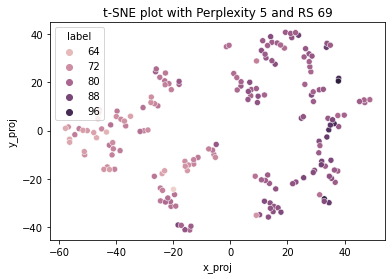

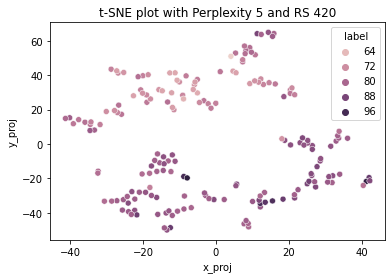

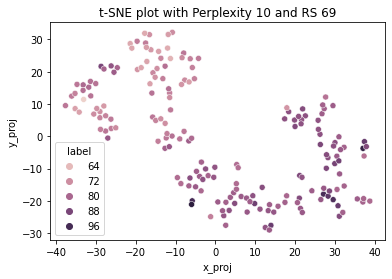

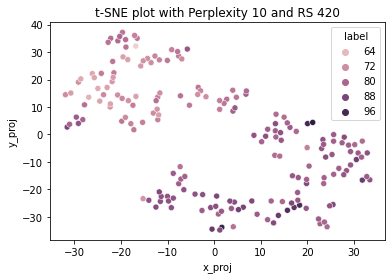

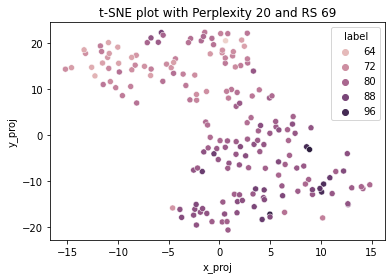

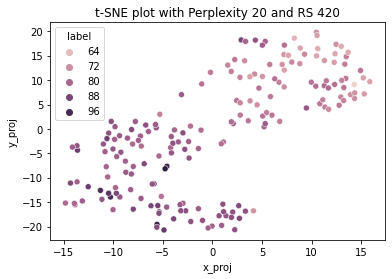

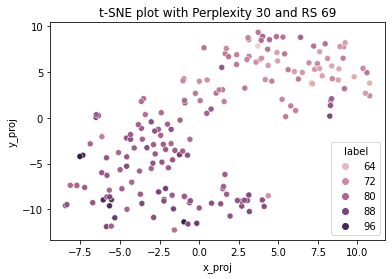

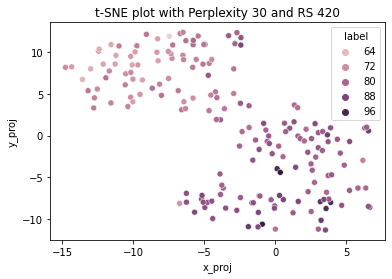

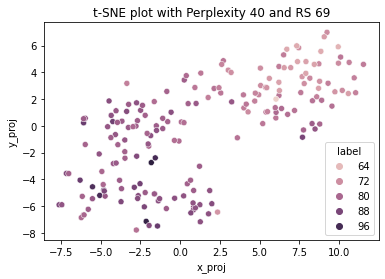

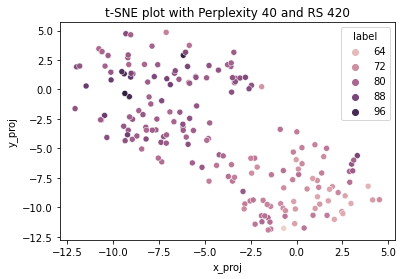

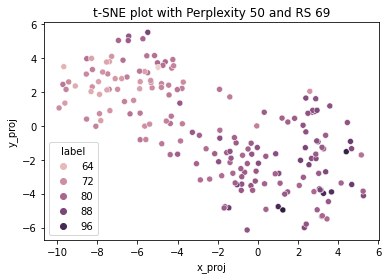

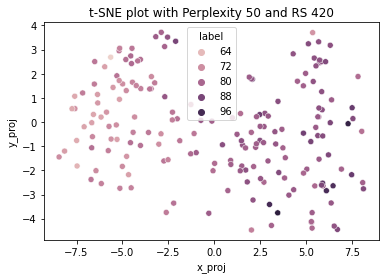

In [13]:
for perp in ([5] + [i for i in range(10, 51, 10)]):
    for rs in [69, 420]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(df_scaled)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_proj', 'y_proj'])
        df_tsne['label'] = df['Movehub Rating']
        sns.scatterplot(x='x_proj', y='y_proj', hue='label', data=df_tsne)
        plt.title("t-SNE plot with Perplexity %d and RS %d" % (perp, rs))
        plt.show()

There seems to be a strong singular clustering structure with some perhaps weaker subcluster structure. For the purposes of this project we will deal with the TSNE plot using perplexity 30 and random state 420.

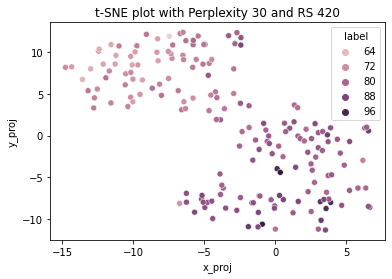

In [14]:
for perp in ([30]):
    for rs in [420]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(df_scaled)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_proj', 'y_proj'])
        df_tsne['label'] = df['Movehub Rating']
        df_combo = pd.concat([df_scaled, df_tsne], axis=1)
        sns.scatterplot(x='x_proj', y='y_proj', hue='label', data=df_tsne)
        plt.title("t-SNE plot with Perplexity %d and RS %d" % (perp, rs))
        plt.show()
df_comboN=df_combo.copy()
df1=df.copy()

## 6. Algorithm Selection Motivation

We chose to use the two algorithms (1) HAC and (2) DBSCAN. The reasonining behind using HAC is that looking at some of the TSNE plots (not the one chosen) we feel like there could potentially by some sub-clustering structure that might be interesting. Especially because we know beforehand that there exists many cities in countries (as shown in the first histogram) we expect that there is some level of subcluster structure just trivially based on this fact. Finally, if in fact the substructure reveals groupings that deviate from the trivial subgroupings based on country, that would be highly interesting as well.

Our choice for DBSCAN mainly lies with the fact that we expect there to be some outliars in this dataset. Mainly due to the pareto distribution, we should see that 20% of the points holds 80% of the variance. This distribution should especially hold true because this data is collected from the real world. Using DBSCAN allows us to see which data points are central to the clustering and which aren't.

## 7. Clustering Algorithm 1: Hierarchical Clustering



### 7.1. Parameter Selection

We can use the average silhouette score to help us select the best clustering algorithm to use for this dataset.

1. **Cluster Closeness** In addition to creating a single partition clustering of the countries, we would like to try to determine the *distances* of the *clusters*. Are some clusters of countries closer than other clusters of countries? Thus, using a hierarchical clustering algorithm (instead of a partition-based clustering algorithm like k-means) might provide us with this additional information.

2. **Outlier Detection** In addition, we would like to determine if there are outlier countries in our dataset that are highly separated from the main clusters of non-outlier countries. Hierarchical agglomerative clustering might be able to determine the existence of these outliers, however, potentially at the expense of identifying the main clusters in the dataset. Our pairwise scatterplots above suggested that that there may be some outliers in this dataset, so it's possible that single linkage may not be able to identify the main clusters as well as other clustering algorithms.

3. **k-means, HAC with single linkage and Ward's linkage not the best choice** In addition, our t-SNE plots suggest the clusters in the dataset might be highly overlapping. k-means, hierarchical agglomerative clustering (HAC) algorithms that use single linkage and Ward's linkage tend to not work as well when the clusters are highly overlapping. This suggests that HAC algorithms with complete linkage and average linkage might perform better.

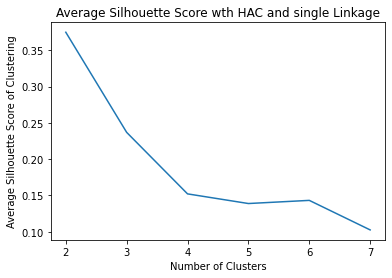

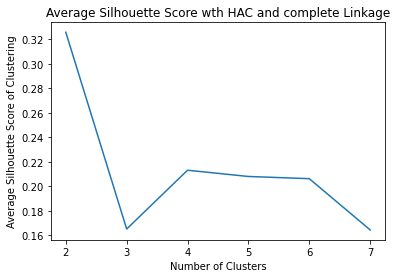

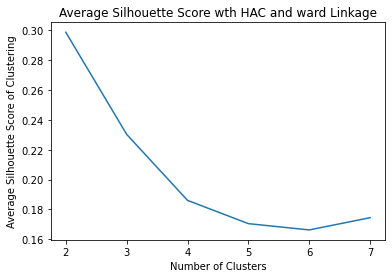

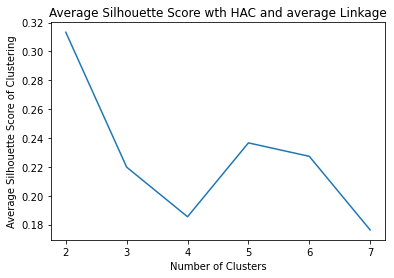

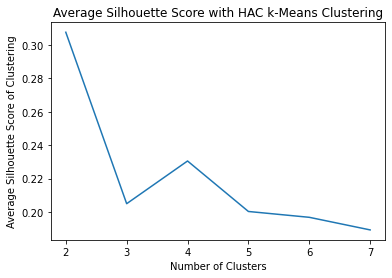

In [15]:
for link in ['single', 'complete', 'ward', 'average']:
    avg_ss=[]
    for k in [2,3,4,5,6,7]:
        hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage=link)
        Y_pred = hac.fit_predict(df_scaled)
        avg_ss.append(silhouette_score(df_scaled, Y_pred))
        
    plt.plot([2,3,4,5,6,7], avg_ss)
    plt.title('Average Silhouette Score wth HAC and %s Linkage'%link)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score of Clustering')
    plt.show()
    

avg_ss=[]
for k in [2,3,4,5,6,7]:
    #First, designate the HAC linkage function, and the number of clusters you want to extract from the resulting dendrogram
    for trial in range(0,3):
        sub_list=[]
        kmeans = KMeans(n_clusters=k)
        Y_pred = kmeans.fit_predict(df_scaled)
        sub_list.append(silhouette_score(df_scaled, Y_pred))
    avg_ss.append(np.average(sub_list))

plt.plot([2,3,4,5,6,7], avg_ss)
plt.title('Average Silhouette Score with HAC k-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score of Clustering')
plt.show()

#### Interpretation

It looks like the clustering and cluster number that produced the highest average silhouette score above is a HAC with average linkage and k=5 clusters. Thus this is a good choice since we know that the average silhouette score plots for HAC algorithms with complete linkage or average linkage tend to be more robust to outliers.

For good measure, we will try out all four linkage functions in HAC and examine what kind of results that we get.

### 7.2. Clustering Algorithm

### HAC with Single Linkage

Let's first examine the dendrogram and clustering results (extracted clustering results with k=2,..., and k=7 clusters) using the HAC with single linkage first.

#### Dendrogram
In the dendrogram, we can see that if we create and extract the clustering with k=2,k=3,...,k=7 clusters, that the HAC with single linkage will just 'pick off' outlier observations one at a time, without revealing any of the actual larger clusters that the t-SNE plot is suggest that there is.

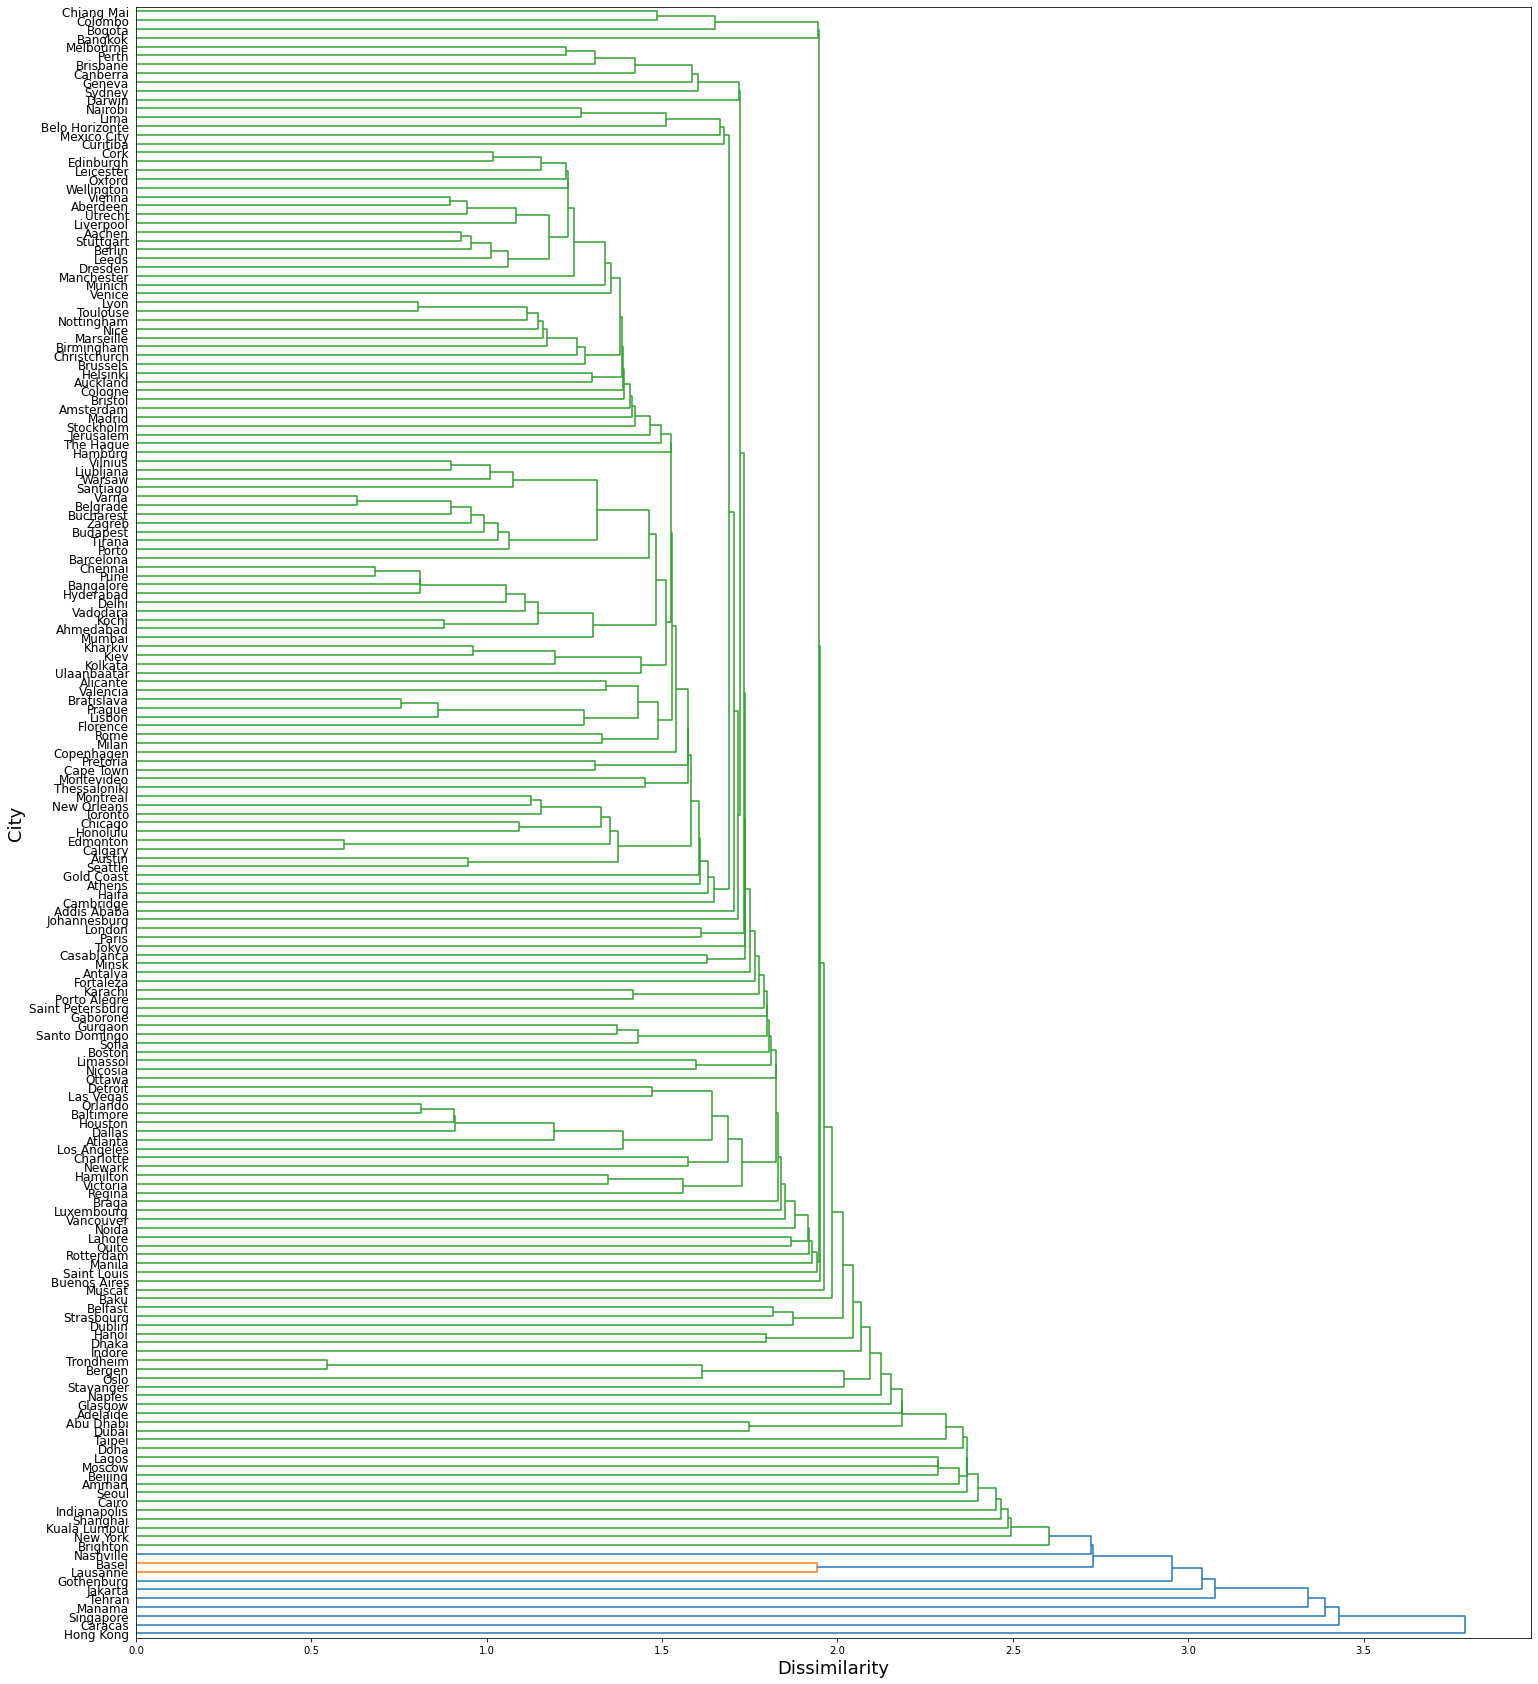

In [16]:
dm = pdist(df_scaled, metric='euclidean')
Z = linkage(dm, method='single')

fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', labels=df_stand['City'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('City', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

### HAC with Complete Linkage

Let's next examine the dendrogram and clustering results (extracted clustering results with k=2,..., and k=7 clusters) using the HAC with complete linkage.

#### Dendrogram
The dendrogram for HAC with complete linkage is below. In the dendrogram, we can see that if we create and extract the clustering with k=2,k=3,...,k=7, the clusters are able to identify larger clusters of data. We don't see singleton clusters getting separated from the rest of the clusters anymore. In addition, we see 2 small cluster comprised of just three countries each: Jakarta, Tehran, and Caracas, and Singapore, Hongkong, and New York.

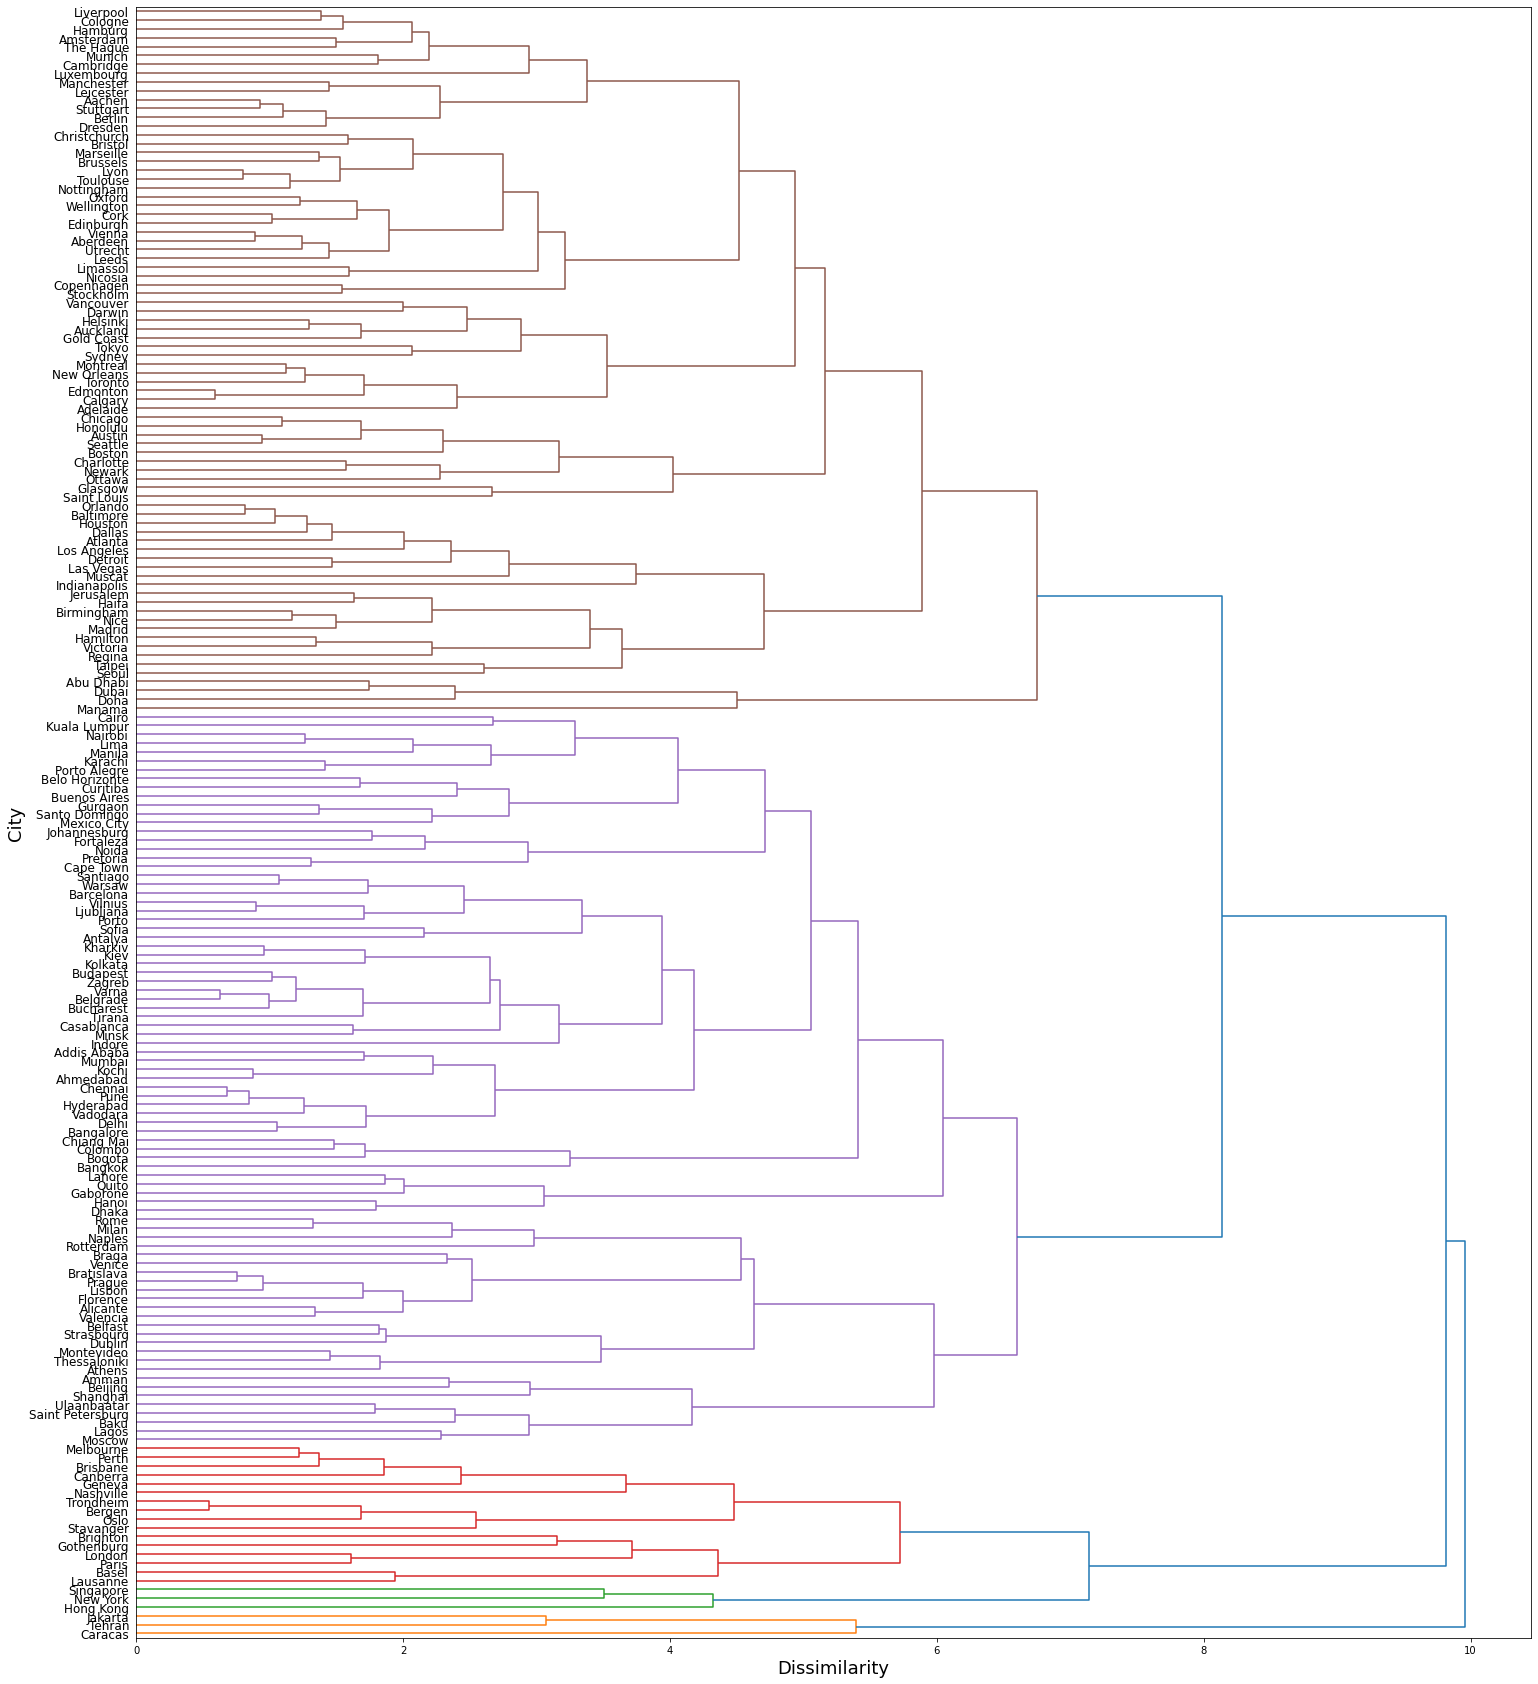

In [17]:
dm = pdist(df_scaled, metric='euclidean')
Z = linkage(dm, method='complete')

fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', labels=df_stand['City'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('City', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

### HAC with Average Linkage

Let's next examine the dendrogram and clustering results (extracted clustering results with k=2,..., and k=7 clusters) using the HAC with average linkage.

#### Dendrogram
The dendrogram for HAC with average linkage is below. In the dendrogram, we can see that if create/extract clusterings with k=2,k=3,...,k=7 clusters, it identifies small clusters of 3, 2, and 1 countries only.

However, if we keep increasing the number of clusters, eventually we find some larger clusters of countries that are created.

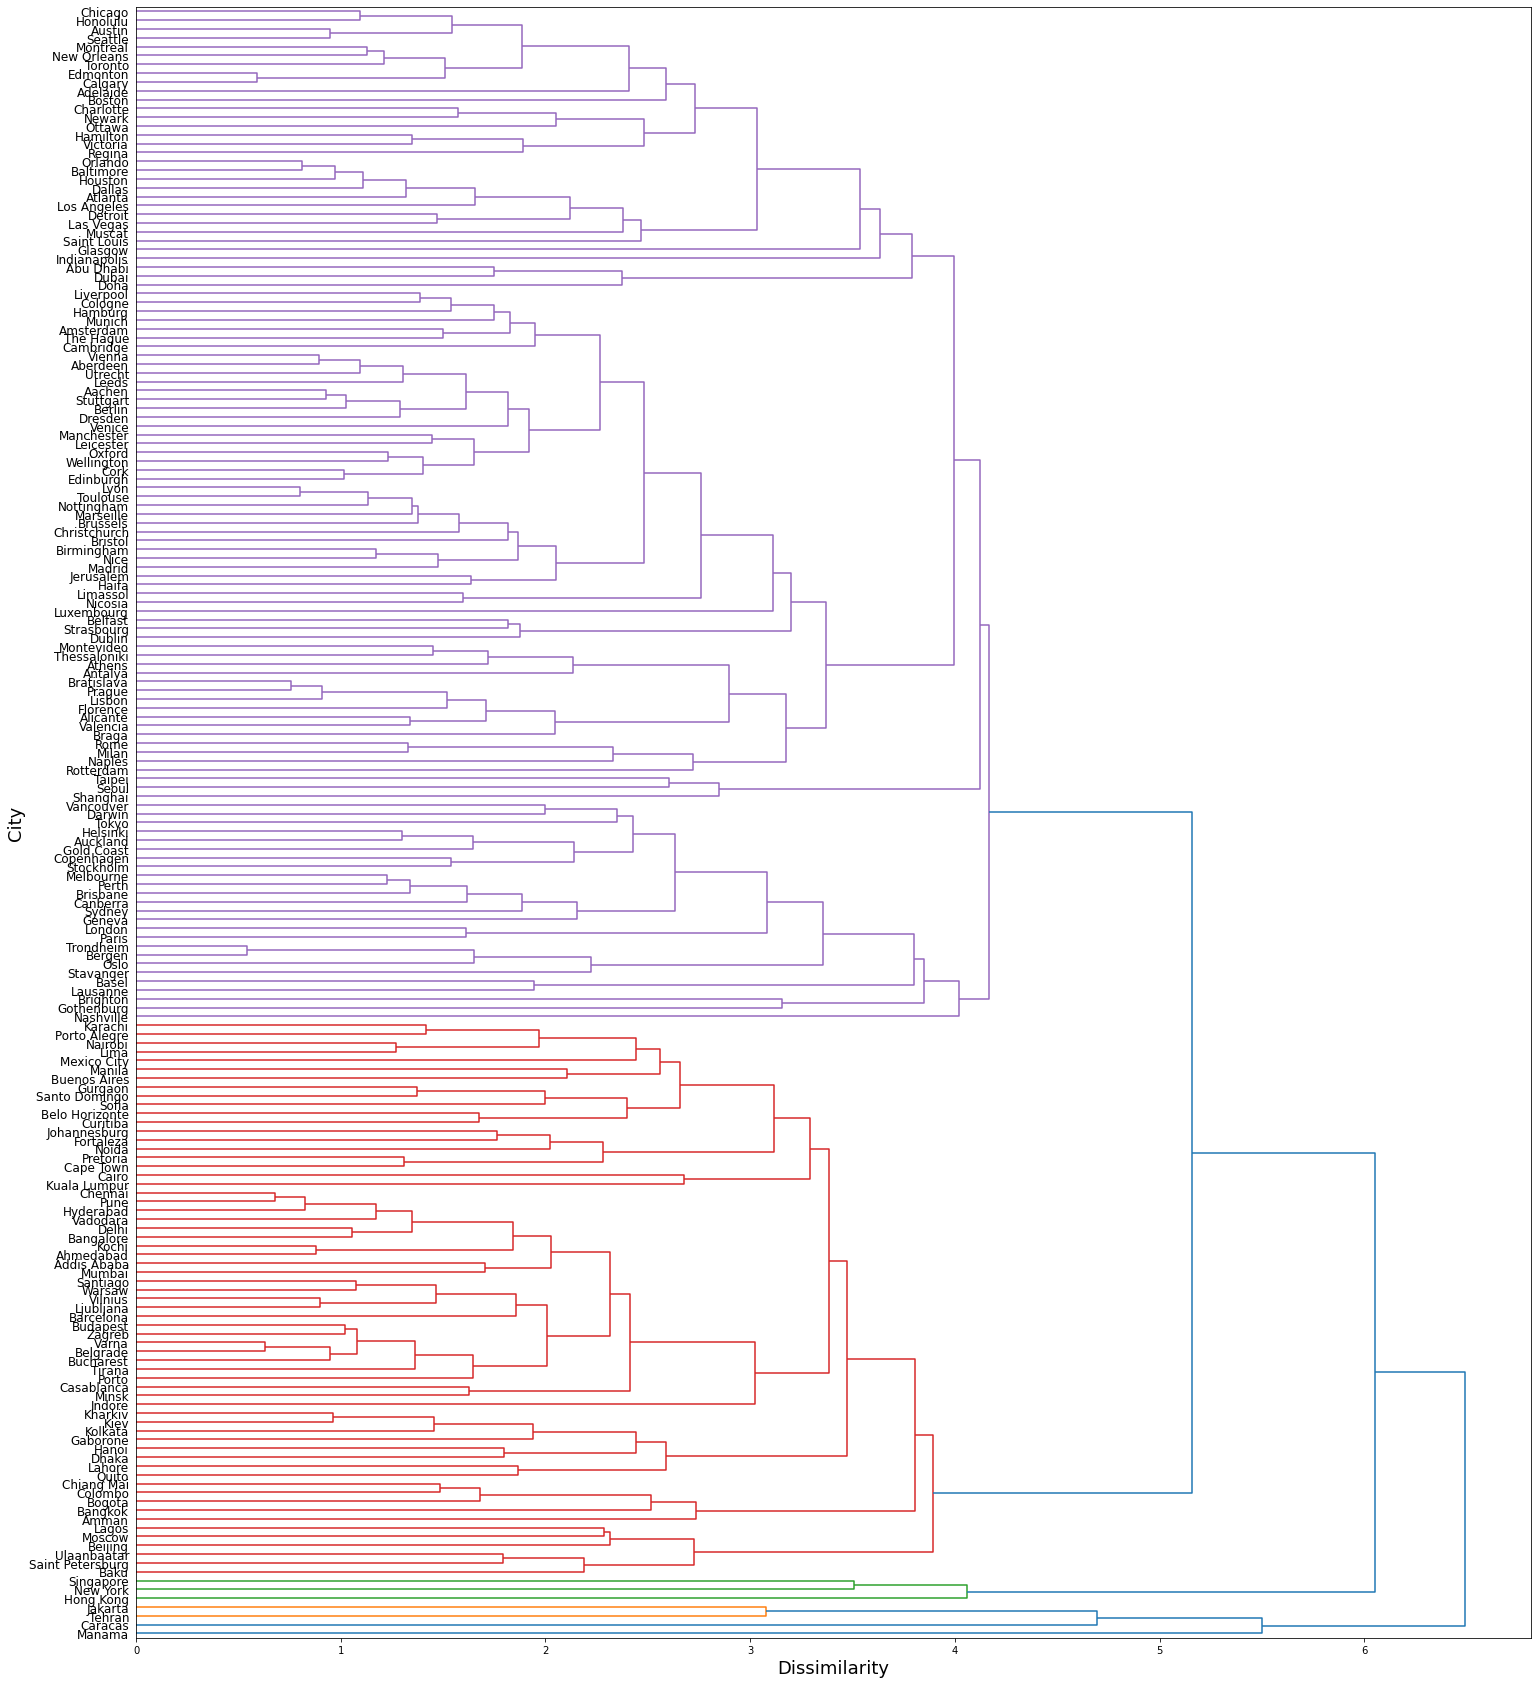

In [18]:
dm = pdist(df_scaled, metric='euclidean')
Z = linkage(dm, method='average')

fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', labels=df_stand['City'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('City', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

### HAC with Ward's Linkage

We'll next examine the dendrogram and clustering results (extracted clustering results with k=2,..., and k=7 clusters) using the HAC with Ward's linkage.

#### Dendrogram
The dendrogram for HAC with Ward's linkage is below. In the dendrogram, we can see that the 2 clusters identified are all large clusters. There are some disagreements, particularly for countries that look like they might be "straddle nodes" between two clusters as shown in the corresponding tsne plot in 7.3.

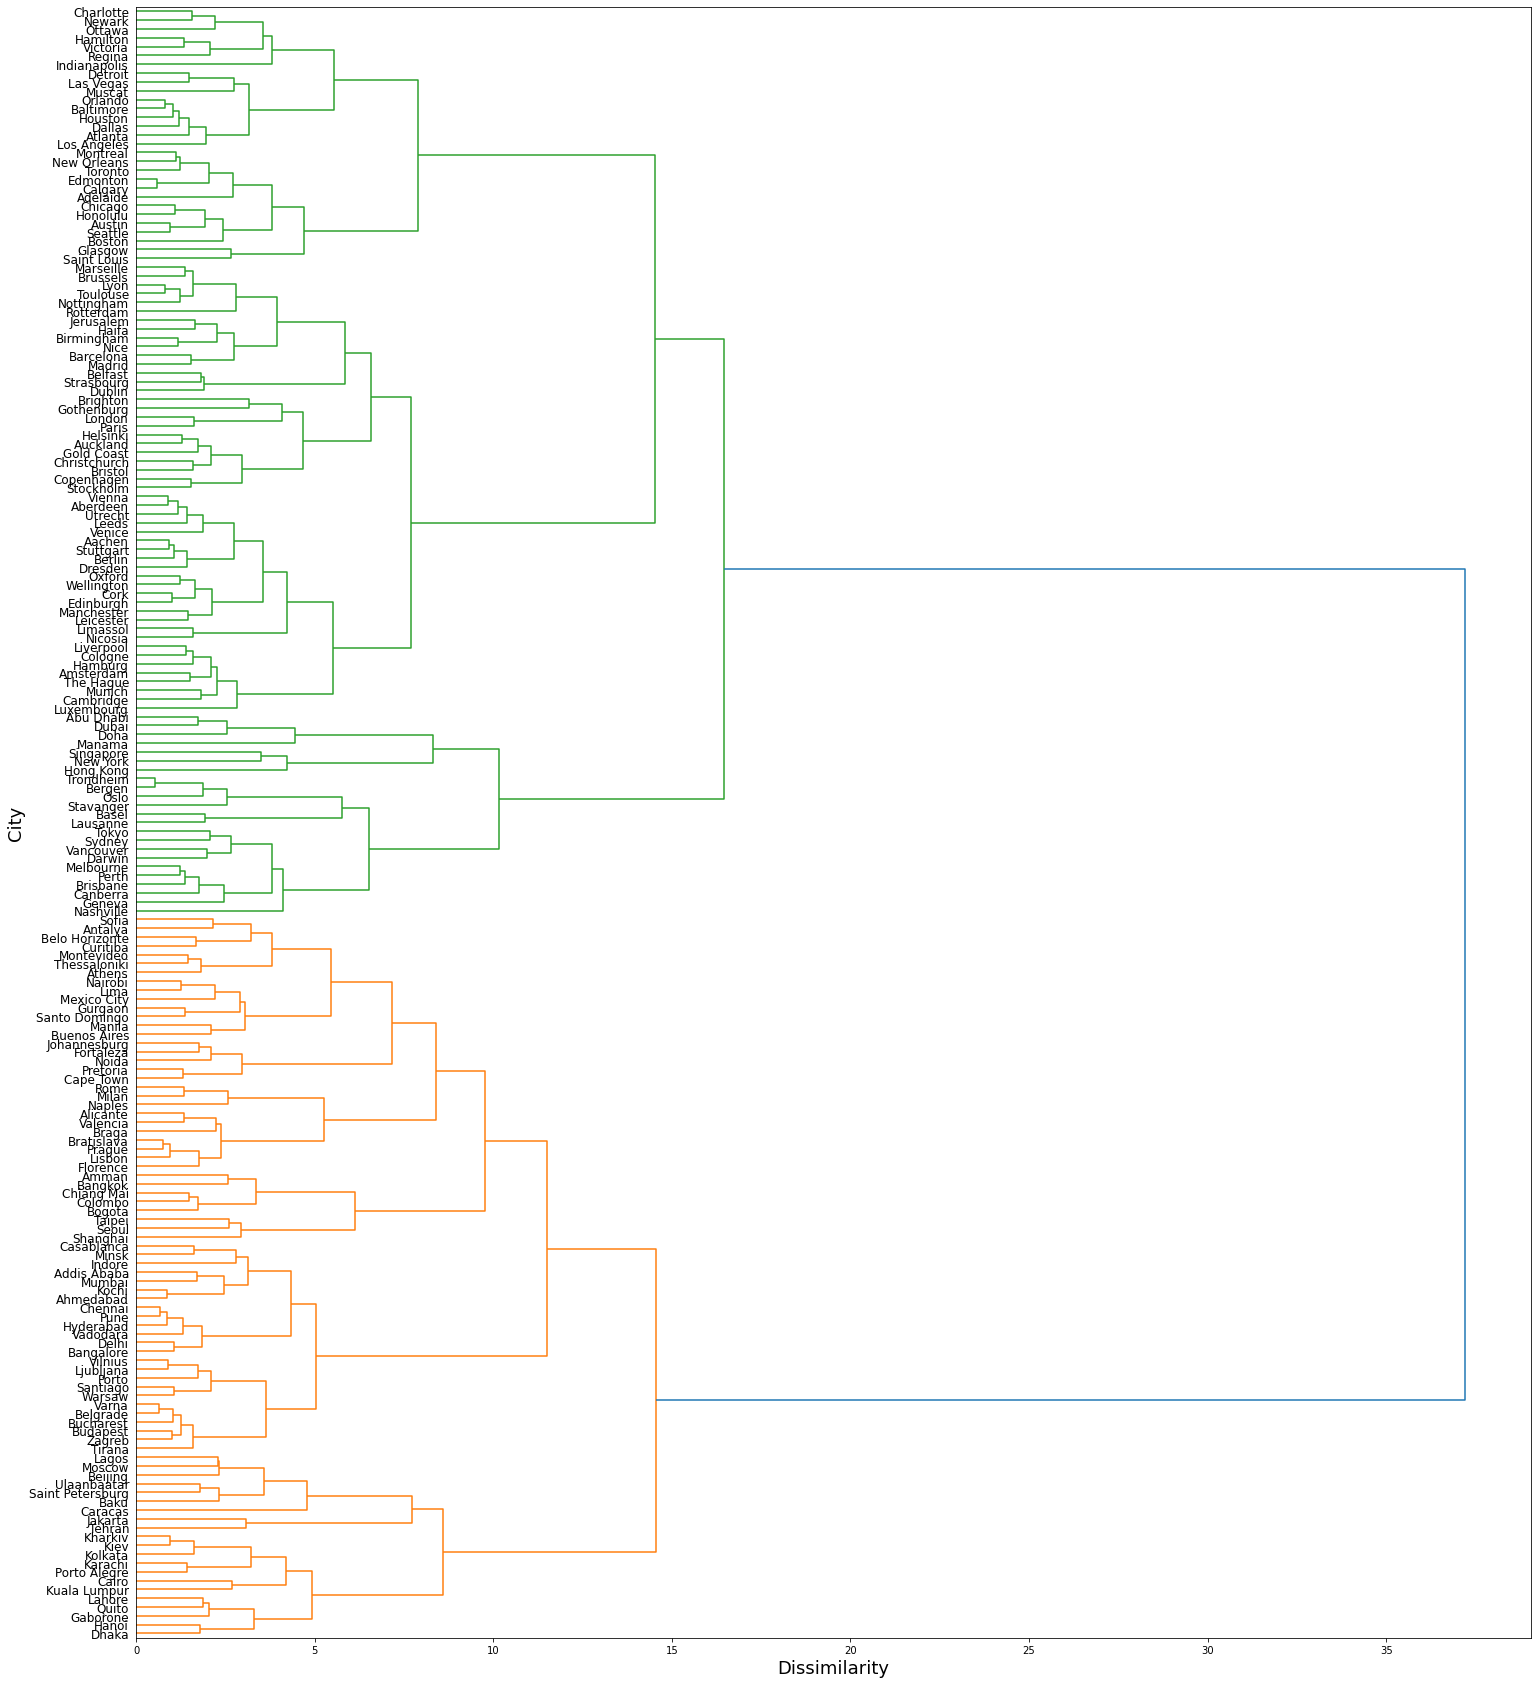

In [19]:
dm = pdist(df_scaled, metric='euclidean')
Z = linkage(dm, method='ward')

fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', labels=df_stand['City'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('City', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

### 7.3. Clustering Algorithm Results Presentation

#### Extracted Clusterings from the Dendrogram with Single Linkage
We can see that outliers are 'picked off' one at a time and make up a clusteron its own. This result is not an uncommon thing to see when HAC with single linkage is applied to a dataset with outliers.

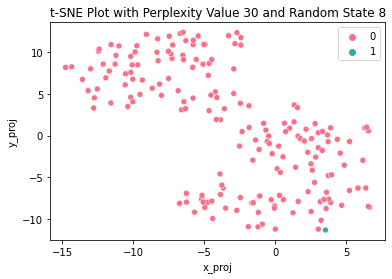

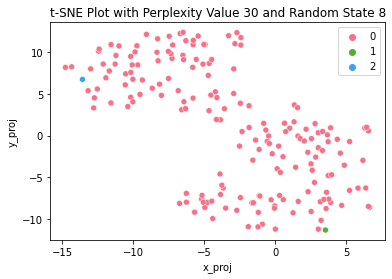

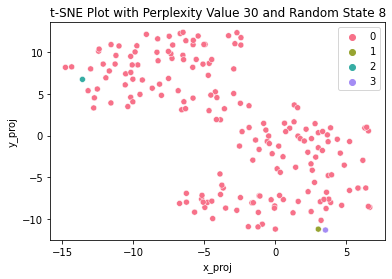

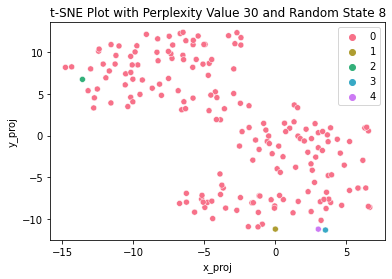

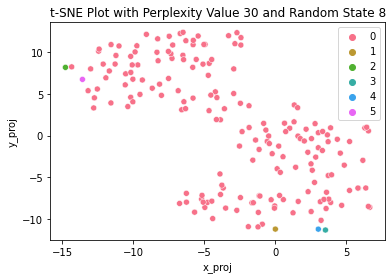

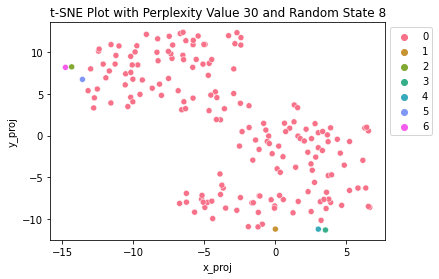

In [20]:
for k in range(2,8):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
    df_combo = pd.concat([df_stand, df_tsne], axis=1)
    df_combo['predicted_cluster'] = hac.fit_predict(df_scaled)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(30, 8))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

#### Extracted Clusterings from the Dendrogram with Complete Linkage

we can see that the clustering with k=4 clusters finally separates the the larger cluster of countries suggested in the bottom right of the t-SNE plot below from the rest of the data. And the clustering with k=7 clusters finally separated the larger cluster suggested in the top left of the t-SNE plot from the larger cluster suggested in the center of the t-SNE plot.

While the t-SNE plot suggests that the three most "main clusters" in this dataset are the large one in the middle of the plot, the 3-city one in the top left of the plot, and the smaller one on the bottom right of the plot, HAC-complete with k=3 clusters decides to split the small cluster of Jakarta, Tehran, and Caracas from the rest of the dataset first.

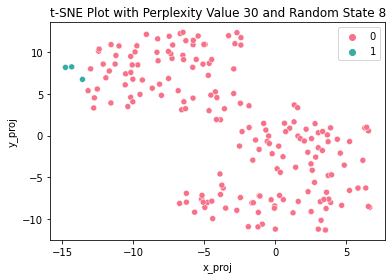

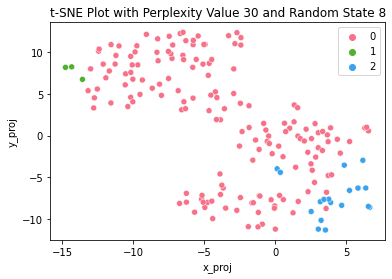

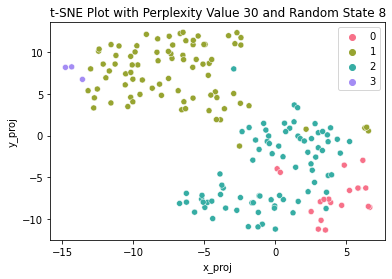

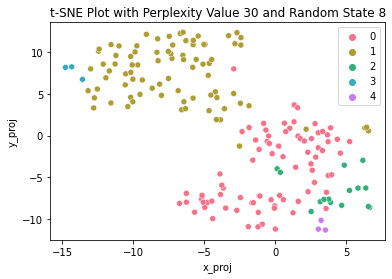

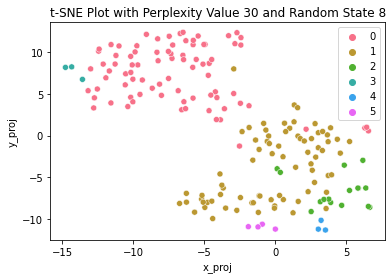

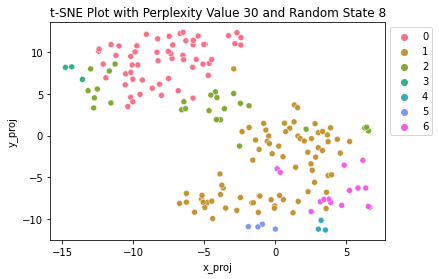

In [21]:
for k in range(2,8):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete')
    df_combo = pd.concat([df_stand, df_tsne], axis=1)
    df_combo['predicted_cluster'] = hac.fit_predict(df_scaled)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(30, 8))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

#### Extracted Clustering from the Dendrogram with Complete Linkage

For instance, we can see that the clustering with k=4 clusters finally separates the the larger cluster of countries suggested in the bottom right of the t-SNE plot below from the rest of the data. And the clustering with k=7 clusters finally separated the larger cluster suggested in the top left of the t-SNE plot from the larger cluster suggested in the center of the t-SNE plot.

Thus, the results suggested by HAC with average linkage are able to identify outliers (found in the singleton clusters) as well as larger cluster structures. However, whether we would consider all of the objects that were "picked off" into singleton clusters as outliers rather than belonging in a larger cluster could be subjective.

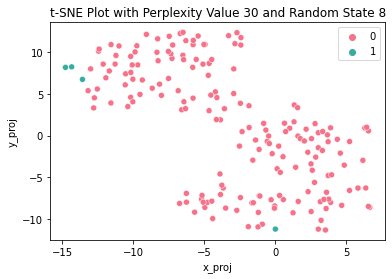

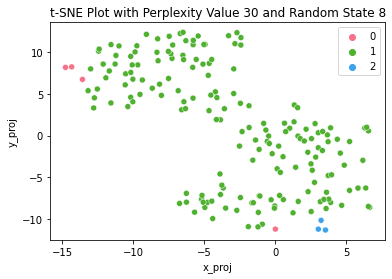

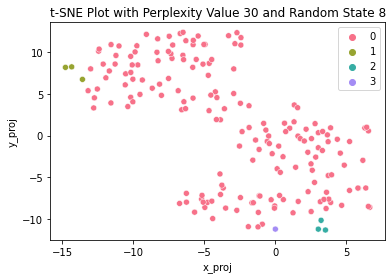

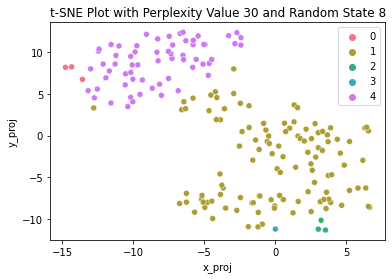

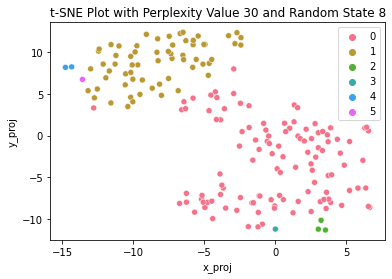

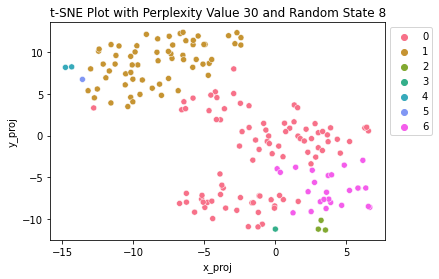

In [22]:
for k in range(2,8):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='average')
    df_combo = pd.concat([df_stand, df_tsne], axis=1)
    df_combo['predicted_cluster'] = hac.fit_predict(df_scaled)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(30, 8))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

#### Extracted Clustering from the Dendrogram with Ward's Linkage

By the time that we get to a clustering with k=6 clusters, it looks like the large "main cluster" in the top left of the t-SNE plot is split in 3-ways. This suggests that using Ward's linkage to cluster the data beyond a clustering with k=6 clusters may communicate distinctions in the dataset that aren't as important or meaningful.

Out of all the tsne plots, Ward's linkage with k=5 clusters seems to return the best results. Because the t-SNE plot suggests that using HAC with Ward's linkage to identify more than k=5 clusters may communcate distinctions in the dataset that aren't as important or meaningful, we will examine the clustering with k=5 clusters.

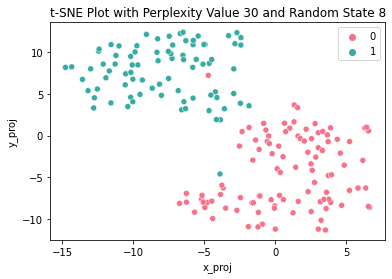

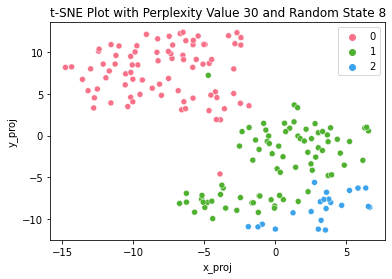

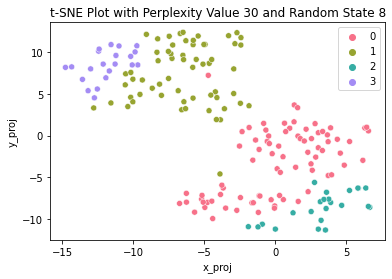

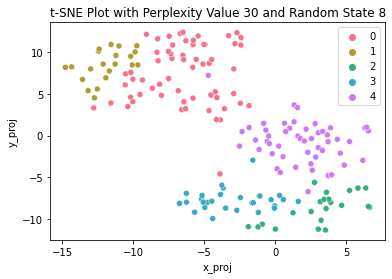

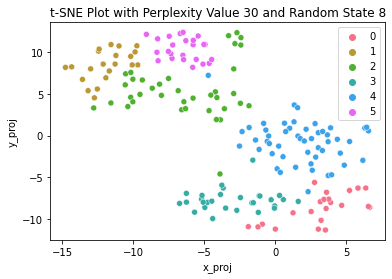

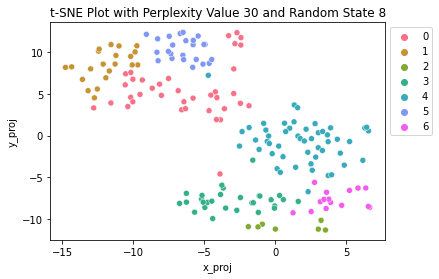

In [23]:
for k in range(2,8):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    df_combo = pd.concat([df_stand, df_tsne], axis=1)
    df_combo['predicted_cluster'] = hac.fit_predict(df_scaled)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(30, 8))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 7.4. Assessing Clustering Separation and Cohesion

#### Silhouette Plot and Average Silhouette Score

In [24]:
def show_silhouette_plots(X,cluster_labels):

    # This package allows us to use "color maps" in our visualizations
    import matplotlib.cm as cm
    
    #How many clusters in your clustering?
    n_clusters=len(np.unique(cluster_labels))    

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient fcan range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.show()
    
    return

In [25]:
#Clustering from dendrogram with k=2 clusters
hac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
df_combo['predicted_cluster2'] = hac.fit_predict(df_scaled)

#Clustering from dendrogram with k=5 clusters
hac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
df_combo['predicted_cluster'] = hac.fit_predict(df_scaled)

For n_clusters = 5 The average silhouette_score is : 0.1704798289572779


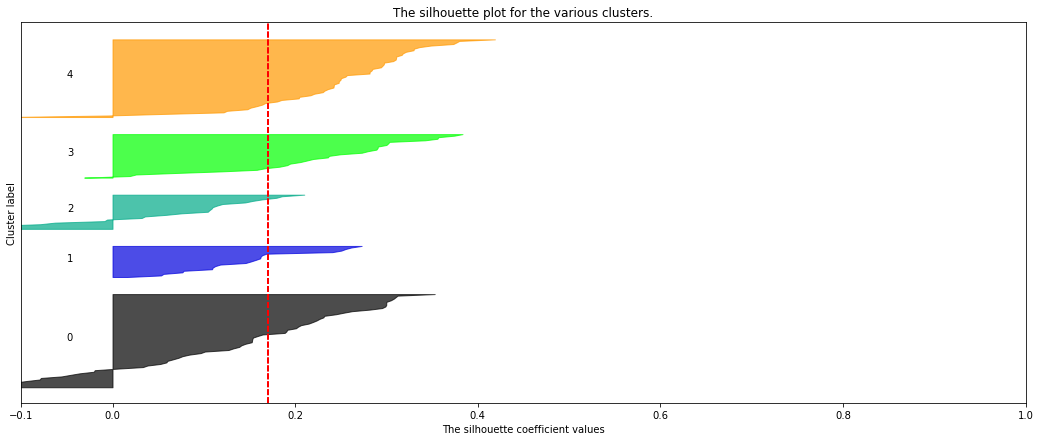

In [26]:
#Silhouette plot and calculate the average silhouette score for k = 5 clusters
show_silhouette_plots(df_scaled, df_combo['predicted_cluster'])

For n_clusters = 2 The average silhouette_score is : 0.2987109010540365


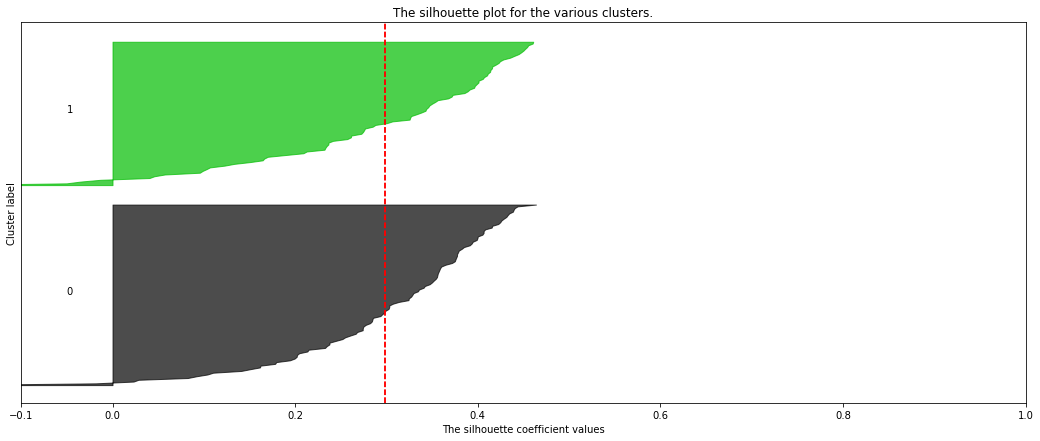

In [27]:
#Silhouette plot and calculate the average silhouette score for k = 2 clusters
show_silhouette_plots(df_scaled, df_combo['predicted_cluster2'])

Most objects in cluster 1, 3, and 4 is exclusively closer to their cluster. As expected the HAC silhouette score is low because the cost function it is fitting is not directly analogous to the cost function used in the silhouette score.

### 7.5. Additional Analysis

We begin by plotting our TSNE plots for HAC with k=2 for wards linkage along with the actual labels (which we describe in Section 2 as the median discretization).

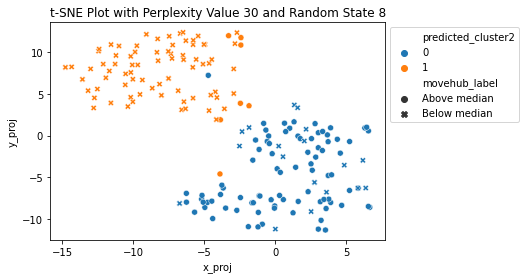

In [28]:
#Map the resulting cluster labels onto our chosen t-SNE plot
plt.figure()
df_combo['movehub_label'] = np.where(df['Movehub Rating']> 80.68, "Above median", 'Below median')
sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster2', style="movehub_label", data=df_combo)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(30, 8))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

#### Rand score: 

In [29]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(df_combo['movehub_label'], df_combo['predicted_cluster2'])

0.5299838543102386

#### Homogeneity Score

In [30]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df_combo['movehub_label'], df_combo['predicted_cluster2'])

0.4412906413194293

#### Completeness Score

In [31]:
from sklearn.metrics import completeness_score
completeness_score(df_combo['movehub_label'], df_combo['predicted_cluster2'])

0.4454304612572522

### 7.6. Describing Each of the Clusters

### Final Insights

Because our overall goal for this analysis was to find *larger* groups of cities that have a set of similar characteristics, we will choose to further analyze the results produced by Ward's linkage since HAC with Ward's linkage completely agrees with the number of clusters suggested by the t-SNE plot (k=5).

Because the t-SNE plot suggests that using HAC with Ward's linkage to identify more than k=5 clusters may communcate distinctions in the dataset that aren't as important or meaningful, we will examine the clustering with k=5 clusters.



##### Map the resulting cluster labels onto our chosen t-SNE plot
sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster', palette=sns.color_palette("husl", 2), data=df_combo)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(30, 8))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

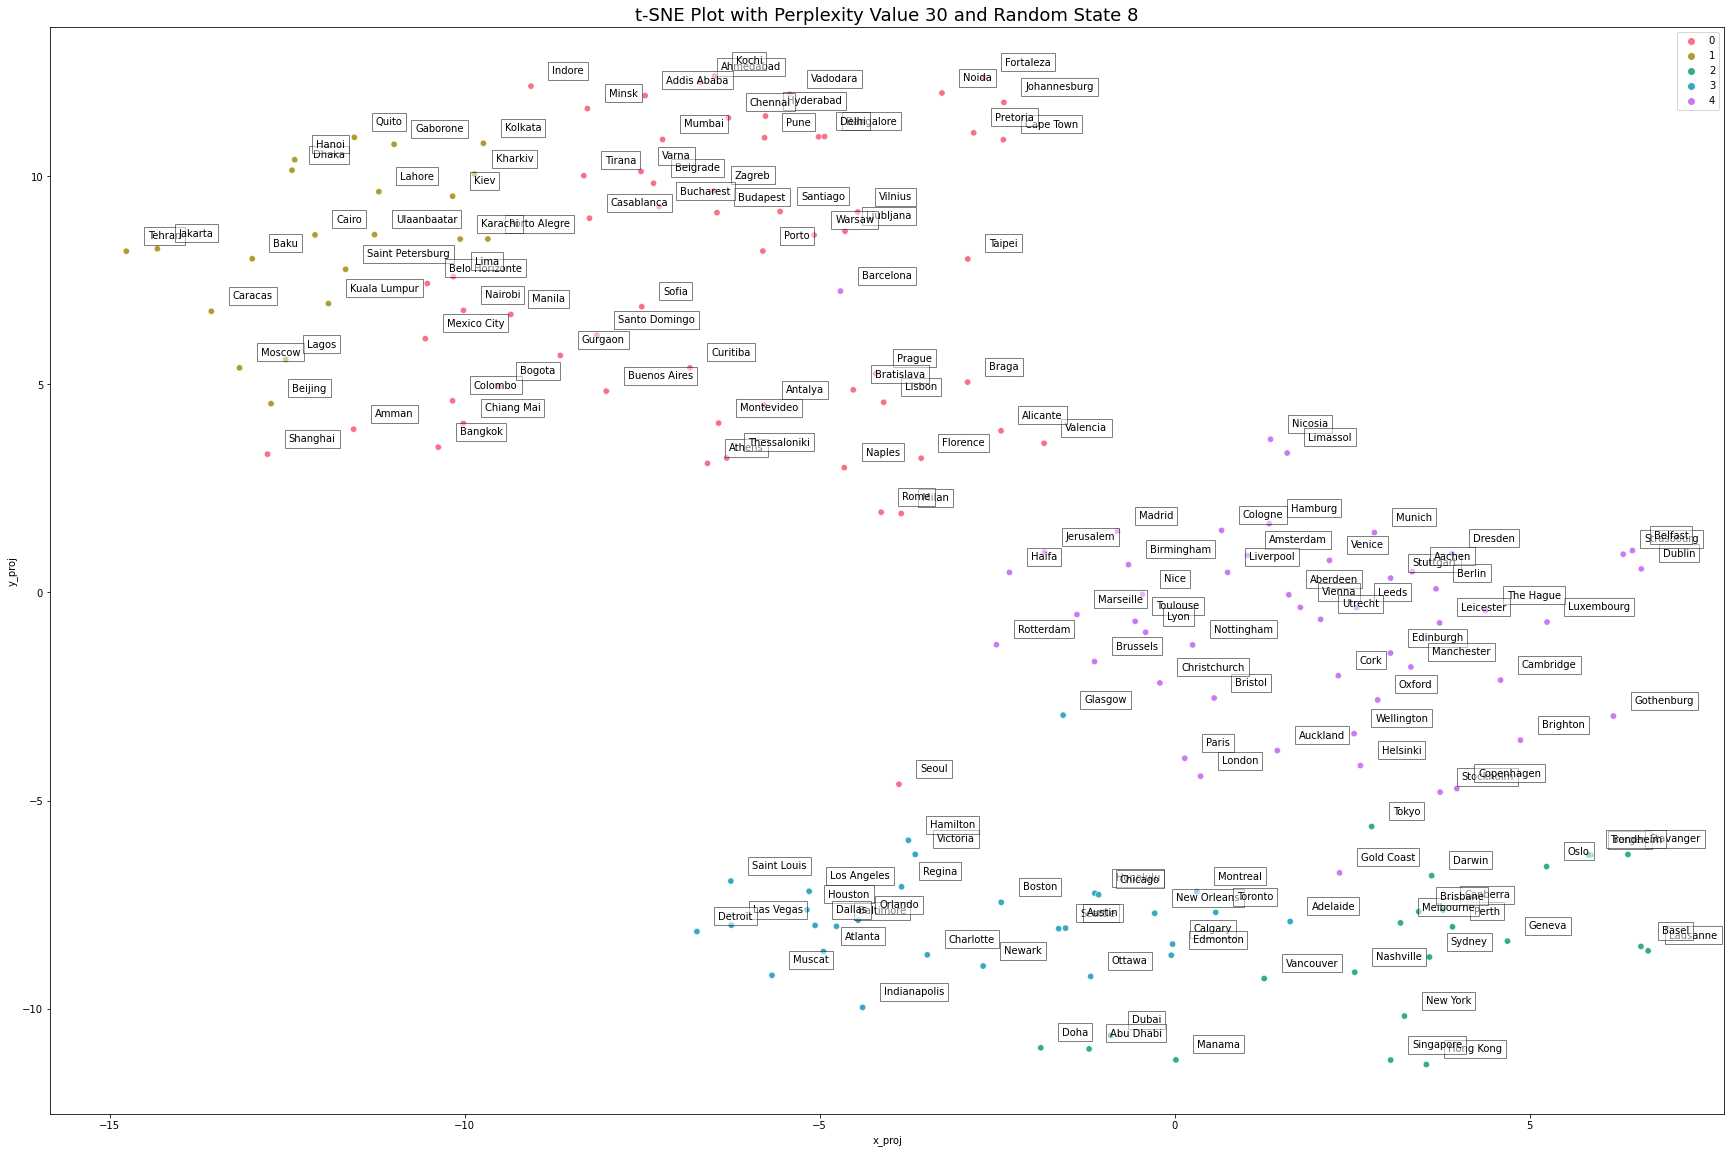

In [32]:
#Map the resulting cluster labels onto our chosen t-SNE plot
plt.figure(figsize=(30,20))
sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster', palette=sns.color_palette("husl", 5), data=df_combo, s=40)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(30, 8), fontsize=18)
plt.legend(bbox_to_anchor=(1,1))


for i in range(df_combo.shape[0]):
 plt.text(x=df_combo.x_proj[i]+0.3,y=df_combo.y_proj[i]+0.3,s=df_combo.City[i], 
          fontdict=dict(color='black',size=10),
          bbox=dict(facecolor='white',alpha=0.5))

plt.show()

### Cluster Characteristics


In [33]:
df['predicted_cluster']=df_combo['predicted_cluster']
df_combo

Cappuccino    Cinema      Wine  Gasoline  Avg Rent  \
0      1.541438  2.245574  0.403426  0.879256  0.909820   
1      1.081026  2.373816  1.023717  0.764381  2.234608   
2      2.001850  1.989090  0.091796  0.678225  0.813923   
3      1.173108  1.820543  0.902033 -0.125896  1.456867   
4      2.449107  2.029395  1.917055 -1.044892  1.714726   
..          ...       ...       ...       ...       ...   
180   -0.734313 -1.169331  0.085861 -2.365949 -0.999152   
181   -1.286807 -1.169331 -0.573013 -0.987455 -1.337140   
182   -0.984250 -1.169331 -0.148604 -1.016174 -1.324840   
183   -1.997157 -1.528409 -0.849028 -0.843862 -0.661386   
184   -1.405198 -1.550393 -0.299967 -0.499238 -1.326218   

     Avg Disposable Income  Purchase Power  Health Care  Pollution  \
0                 3.160138        2.223871    -0.009529   1.610749   
1                 2.776835        0.769678     0.596406  -0.636148   
2                 2.699865        1.603809     0.922524   0.512592   
3                 2.161631        0.813476     0.977548  -0.863965   
4                 1.865894        1.708629    -0.381947  -1.772531   
..                     ...             ...          ...        ...   
180              -1.353663       -1.657422    -0.638278   1.554374   
181              -1.379892       -1.523076    -0.967751   0.916099   
182              -1.387208       -1.630356    -1.144230  -0.592901   
183              -1.396813       -1.929069    -0.141049   1.532364   
184              -1.400708       -0.481765    -2.325233   0.521859   

     Quality of Life  Crime Rating         City        Country     x_proj  \
0           0.641409     -0.373484     Lausanne    Switzerland   6.669863   
1           1.073656      0.785196       Geneva    Switzerland   4.687998   
2           1.323047     -0.831166        Basel    Switzerland   6.568435   
3           0.705228      0.517240        Perth      Australia   3.914044   
4           0.971365     -0.992555    Nashville  United States   2.537333   
..               ...           ...          ...            ...        ...   
180        -1.891424      0.443321        Cairo          Egypt -12.109833   
181        -1.834847      2.017179      Karachi       Pakistan -10.064808   
182        -1.381327      0.638590       Lahore       Pakistan -11.210537   
183        -1.386305     -0.959292  Addis Ababa       Ethiopia  -7.459849   
184        -0.475644     -1.520460       Indore          India  -9.067728   

        y_proj  label  predicted_cluster  predicted_cluster2 movehub_label  
0    -8.606755  87.21                  2                   0  Above median  
1    -8.372707  83.27                  2                   0  Above median  
2    -8.500251  84.20                  2                   0  Above median  
3    -8.029234  95.38                  2                   0  Above median  
4    -9.120219  80.61                  2                   0  Below median  
..         ...    ...                ...                 ...           ...  
180   8.588047  67.93                  1                   1  Below median  
181   8.487762  67.81                  1                   1  Below median  
182   9.625577  67.32                  1                   1  Below median  
183  11.931819  59.88                  0                   1  Below median  
184  12.161114  76.38                  0                   1  Below median  

[185 rows x 19 columns]

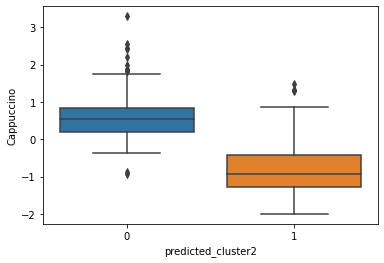

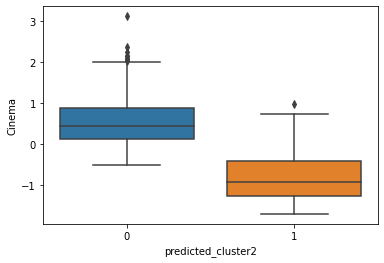

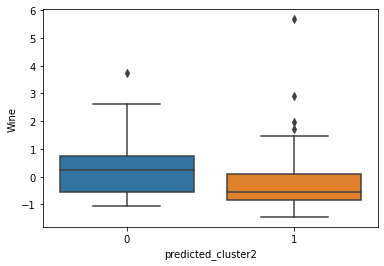

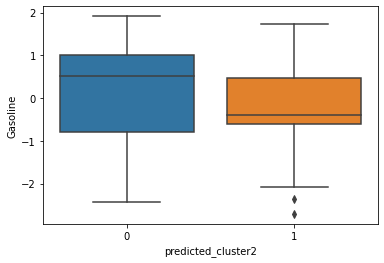

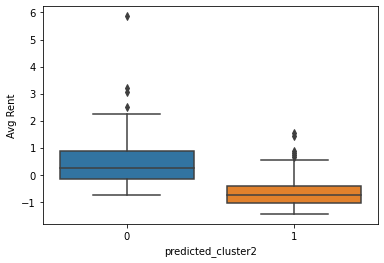

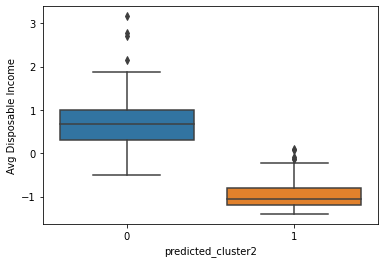

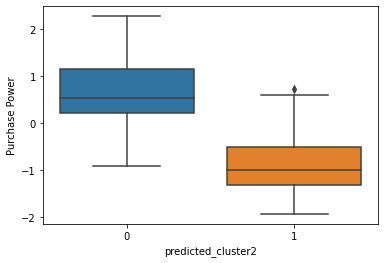

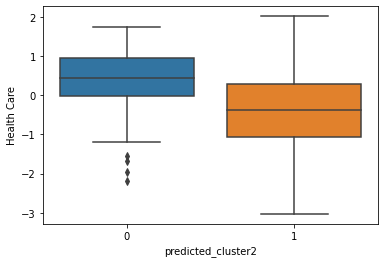

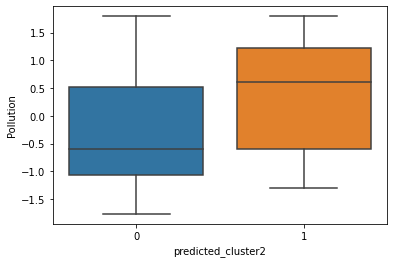

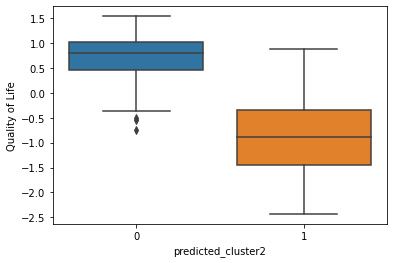

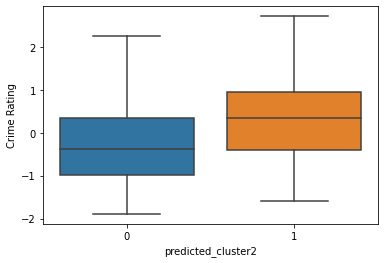

In [34]:
# Ward's Linkage with k=2 clusters
for col in df.columns[2:14]:
    if col == "Movehub Rating":
        continue
    sns.boxplot(x="predicted_cluster2", y=col, data=df_combo)
    plt.show()

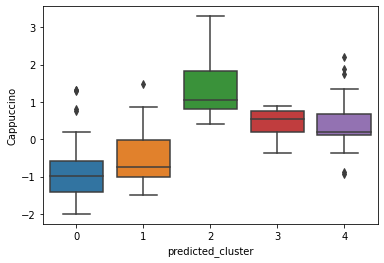

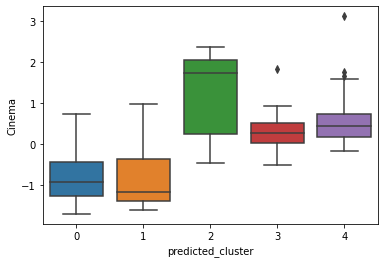

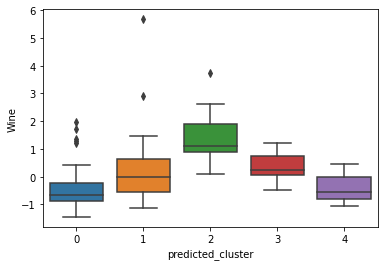

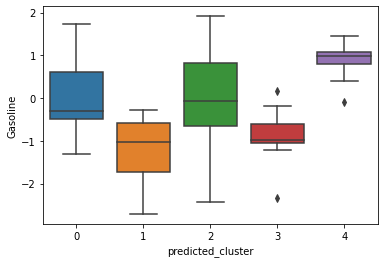

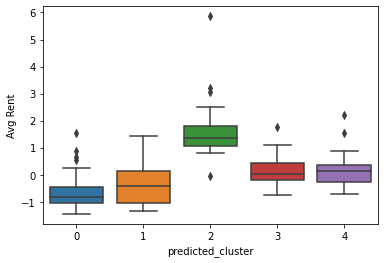

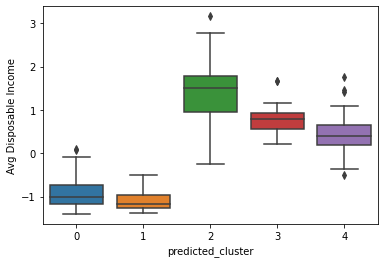

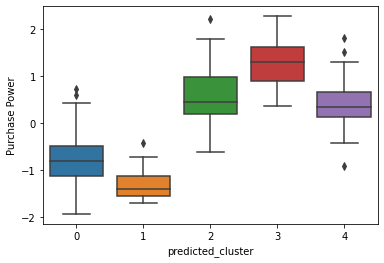

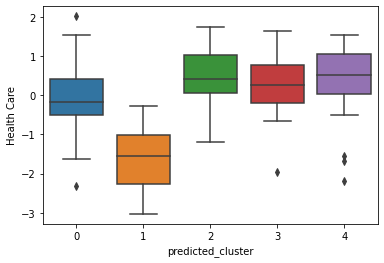

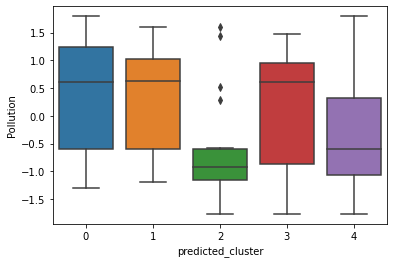

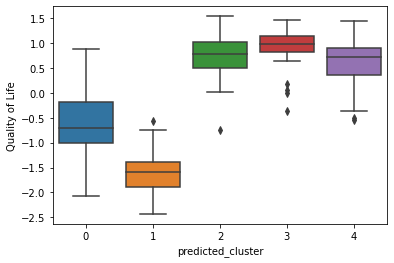

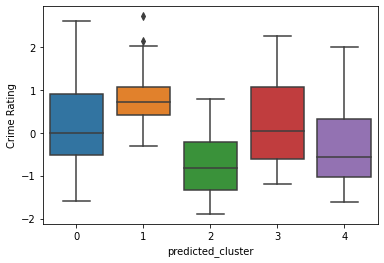

In [35]:
for col in df.columns[2:14]:
    if col == "Movehub Rating":
        continue
    sns.boxplot(x="predicted_cluster", y=col, data=df_combo)
    plt.show()

#### <u>Cluster Similarity</u>

In our HAC-Ward's linkage clustering with k=5 clusters, cluster 0 and cluster 1 described below were the most similar to each other. This is because they were joined earlier in the HAC algorithm with the clustering that had k=3 clusters.

Also, cluster 3 and cluster 4 described below are also very similar to each other, as similar as clister 0 and cluster 1. This is because they were joined earlier in the HAC algorithm with the clustering that had k=3 clusters.

Cluster 0 and cluster 1 both have the following attributes: low Cappuccino score, low cinema score, low wine score, low average rent, low average disposible income, medium Movehub Rating, low purchasing power, and almost equal pollution.

Cluster 3 and cluster 4 have the following attributes: medium Cappucino score, medium Cinema score, low Wine score, low-to-medium Average Rent, average Disposible Income, average Movehub Rating, high Health Care, High Quality of Life, and medium Crime Rating.

In [36]:
df[df['predicted_cluster']==0].head()

City      Country  Cappuccino  Cinema   Wine  Gasoline  Avg Rent  \
93       Milan        Italy        1.19    6.82   4.26      1.53   1704.96   
95       Seoul  South Korea        2.59    5.25  11.67      1.17   1458.20   
97   Fortaleza       Brazil        1.46    5.20   5.85      0.88    650.26   
99    Florence        Italy        1.02    6.82   4.26      1.53   1278.72   
100       Rome        Italy        1.02    6.82   4.26      1.53   2131.21   

     Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
93                 1491.84           81.90           43.43        71.36   
95                 1458.20           82.43           54.30        75.00   
97                 1307.54           80.17           52.28        45.46   
99                 1278.72           76.63           35.31        67.11   
100                1270.20           79.07           32.72        61.64   

     Pollution  Quality of Life  Crime Rating  discrete_label  \
93       22.09            40.80         56.20             1.0   
95       85.59            60.28         21.35             1.0   
97       66.32            36.68         78.65             0.0   
99       29.44            53.73         39.58             0.0   
100      19.84            26.80         62.34             0.0   

     predicted_cluster  
93                   0  
95                   0  
97                   0  
99                   0  
100                  0

In [37]:
df[df['predicted_cluster']==1].head()

City   Country  Cappuccino  Cinema   Wine  Gasoline  \
114            Moscow    Russia        3.10    7.24   7.03      0.62   
120      Kuala Lumpur  Malaysia        1.72    2.57  10.72      0.41   
126  Saint Petersburg    Russia        2.07    6.20   6.20      0.62   
130           Beijing     China        2.64    8.46  10.36      0.86   
137          Gaborone  Botswana        1.19    2.58   3.53      0.71   

     Avg Rent  Avg Disposable Income  Movehub Rating  Purchase Power  \
114   2067.19                 930.24           76.35           24.94   
120    857.82                 702.18           77.88           37.09   
126   1033.60                 620.16           73.10           24.82   
130   1586.25                 600.13           74.17           22.97   
137    395.15                 529.22           75.32           30.98   

     Health Care  Pollution  Quality of Life  Crime Rating  discrete_label  \
114        42.30      30.03            18.65         53.19             0.0   
120        56.21      69.65            42.40         68.91             0.0   
126        46.34      77.98            25.97         56.96             0.0   
130        58.90      57.18            25.69         47.61             0.0   
137        27.78      30.55            31.77         50.00             0.0   

     predicted_cluster  
114                  1  
120                  1  
126                  1  
130                  1  
137                  1

In [38]:
df[df['predicted_cluster']==3].head()

City        Country  Cappuccino  Cinema   Wine  Gasoline  Avg Rent  \
9   Adelaide      Australia        2.49   11.42  10.08      0.95   1382.26   
10    Ottawa         Canada        2.39    7.65   9.56      0.80   1020.02   
20    Boston  United States        2.62    7.85   7.85      0.65   2288.19   
22    Newark  United States        2.45    7.19  10.46      0.67    980.65   
24   Seattle  United States        2.45    7.11   7.52      0.66   1634.42   

    Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
9                 2911.69           87.29           72.03        56.25   
10                2900.68           87.69           91.85        66.02   
20                2451.63           82.20           59.28        78.04   
22                2402.60           84.97           84.39        79.72   
24                2373.83           85.38           78.46        75.46   

    Pollution  Quality of Life  Crime Rating  discrete_label  \
9       12.01            91.54         41.32             1.0   
10      33.55            86.11         22.25             1.0   
20      61.77            82.81         40.69             1.0   
22      62.14            73.21         30.21             1.0   
24      32.90            84.10         42.03             1.0   

    predicted_cluster  
9                   3  
10                  3  
20                  3  
22                  3  
24                  3

In [39]:
df[df['predicted_cluster']==4].head()

City         Country  Cappuccino  Cinema  Wine  Gasoline  Avg Rent  \
7   Luxembourg      Luxembourg        2.13    7.25  4.26      1.15   1704.96   
15   Cambridge  United Kingdom        1.99    8.22  7.97      1.39   1345.20   
16  Gold Coast       Australia        2.69   10.08  8.06      0.98   1310.36   
23   The Hague     Netherlands        2.26    8.10  4.05      1.52   1363.97   
26  Gothenburg          Sweden        3.30   10.76  8.01      1.44   1001.25   

    Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
7                 2983.69           85.85           76.44        59.72   
15                2730.26           82.15           54.76        81.48   
16                2687.92           82.03           56.11        82.23   
23                2386.95           83.23           68.28        66.74   
26                2302.88           74.63           26.95        68.24   

    Pollution  Quality of Life  Crime Rating  discrete_label  \
7       57.17            81.41         18.75             1.0   
15      57.18            70.61         24.22             1.0   
16      30.55            81.31         43.02             1.0   
23      37.21            79.99         29.76             1.0   
26      92.42            71.51         25.62             0.0   

    predicted_cluster  
7                   4  
15                  4  
16                  4  
23                  4  
26                  4

#### <u>Cluster Difference</u>

The cities in cluster 0 and cluster 1 shown below are most dissimilar from the cities in the rest of the clusters (cluster 2, 3, and 4). This is because the countries in cluster 0 and cluster 1 were merged last in the HAC algorithm with the clustering that had k=1 cluster.

In [40]:
df[df['predicted_cluster']==0]

City      Country  Cappuccino  Cinema   Wine  Gasoline  Avg Rent  \
93         Milan        Italy        1.19    6.82   4.26      1.53   1704.96   
95         Seoul  South Korea        2.59    5.25  11.67      1.17   1458.20   
97     Fortaleza       Brazil        1.46    5.20   5.85      0.88    650.26   
99      Florence        Italy        1.02    6.82   4.26      1.53   1278.72   
100         Rome        Italy        1.02    6.82   4.26      1.53   2131.21   
..           ...          ...         ...     ...    ...       ...       ...   
175   Casablanca      Morocco        1.70    3.94   3.45      0.85    997.08   
176   Chiang Mai     Thailand        1.05    3.53  11.40      0.82    426.24   
177       Manila  Philippines        1.58    2.77   4.75      0.86    791.68   
183  Addis Ababa     Ethiopia        0.46    2.29   4.18      0.72    653.77   
184       Indore        India        0.91    2.23   6.03      0.84    205.15   

     Avg Disposable Income  Movehub Rating  Purchase Power  Health Care  \
93                 1491.84           81.90           43.43        71.36   
95                 1458.20           82.43           54.30        75.00   
97                 1307.54           80.17           52.28        45.46   
99                 1278.72           76.63           35.31        67.11   
100                1270.20           79.07           32.72        61.64   
..                     ...             ...             ...          ...   
175                 230.09           68.27           13.20        53.70   
176                 227.95           68.64           15.89        85.91   
177                 221.67           68.31           14.80        80.56   
183                 124.22           59.88            6.38        63.89   
184                 120.68           76.38           35.79        31.34   

     Pollution  Quality of Life  Crime Rating  discrete_label  \
93       22.09            40.80         56.20             1.0   
95       85.59            60.28         21.35             1.0   
97       66.32            36.68         78.65             0.0   
99       29.44            53.73         39.58             0.0   
100      19.84            26.80         62.34             0.0   
..         ...              ...           ...             ...   
175      62.97            48.69         38.28             0.0   
176      30.55            37.50         37.78             0.0   
177      65.22            13.14         66.36             0.0   
183      85.59            28.41         26.04             0.0   
184      59.42            48.53         16.93             0.0   

     predicted_cluster  
93                   0  
95                   0  
97                   0  
99                   0  
100                  0  
..                 ...  
175                  0  
176                  0  
177                  0  
183                  0  
184                  0  

[61 rows x 16 columns]

In [41]:
df[df['predicted_cluster']==1].head()

City   Country  Cappuccino  Cinema   Wine  Gasoline  \
114            Moscow    Russia        3.10    7.24   7.03      0.62   
120      Kuala Lumpur  Malaysia        1.72    2.57  10.72      0.41   
126  Saint Petersburg    Russia        2.07    6.20   6.20      0.62   
130           Beijing     China        2.64    8.46  10.36      0.86   
137          Gaborone  Botswana        1.19    2.58   3.53      0.71   

     Avg Rent  Avg Disposable Income  Movehub Rating  Purchase Power  \
114   2067.19                 930.24           76.35           24.94   
120    857.82                 702.18           77.88           37.09   
126   1033.60                 620.16           73.10           24.82   
130   1586.25                 600.13           74.17           22.97   
137    395.15                 529.22           75.32           30.98   

     Health Care  Pollution  Quality of Life  Crime Rating  discrete_label  \
114        42.30      30.03            18.65         53.19             0.0   
120        56.21      69.65            42.40         68.91             0.0   
126        46.34      77.98            25.97         56.96             0.0   
130        58.90      57.18            25.69         47.61             0.0   
137        27.78      30.55            31.77         50.00             0.0   

     predicted_cluster  
114                  1  
120                  1  
126                  1  
130                  1  
137                  1

## 8. Clustering Algorithm 2 (change name to the algorithm you chose)



### 8.1. Parameter Selection

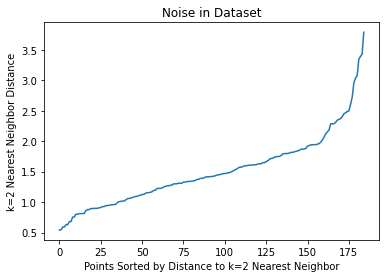

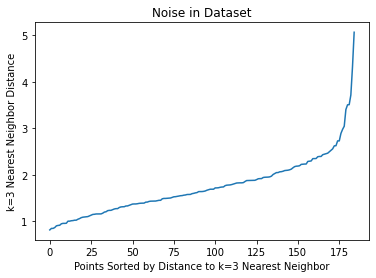

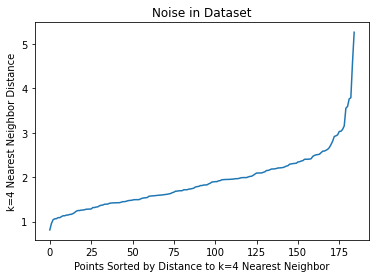

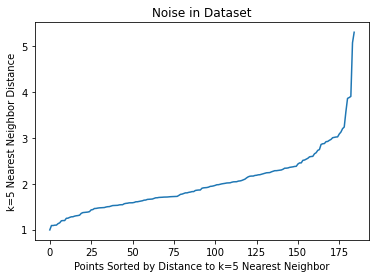

In [42]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

for k in range(2,6):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(df_scaled)
    distances, indices = nbrs.kneighbors(df_scaled)

    plt.plot(np.sort(distances.T[k-1]))
    #plt.axvline(x=3841, color='black')
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noise in Dataset')
    plt.show()

In [43]:


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

from sklearn.preprocessing import StandardScaler

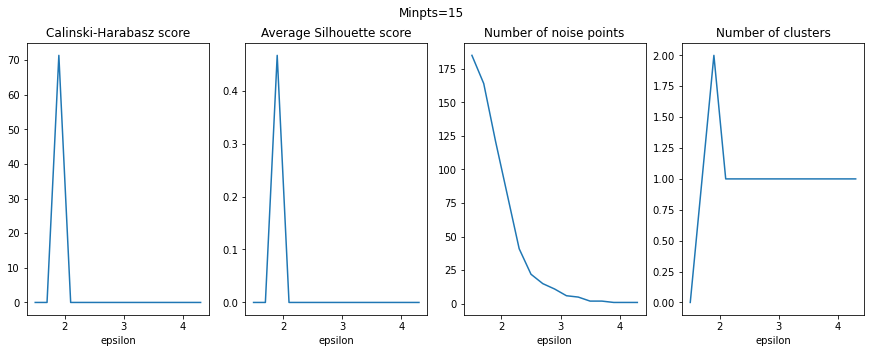

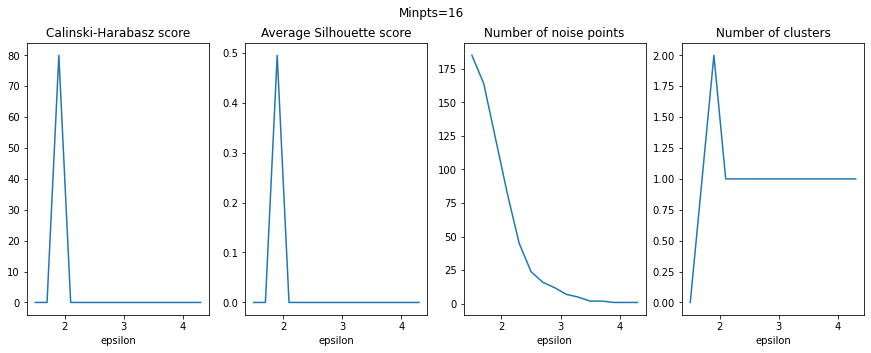

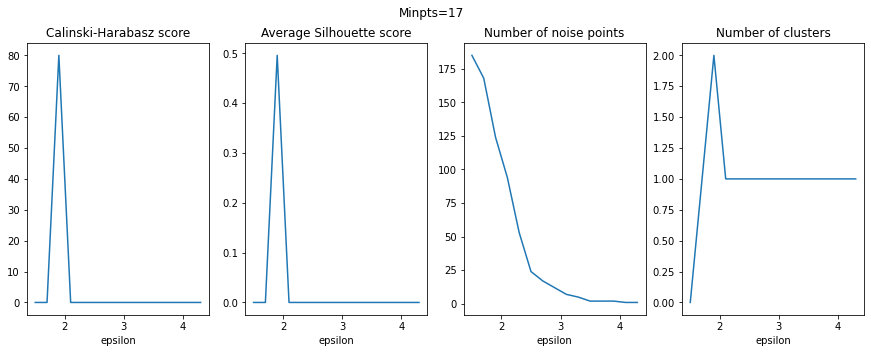

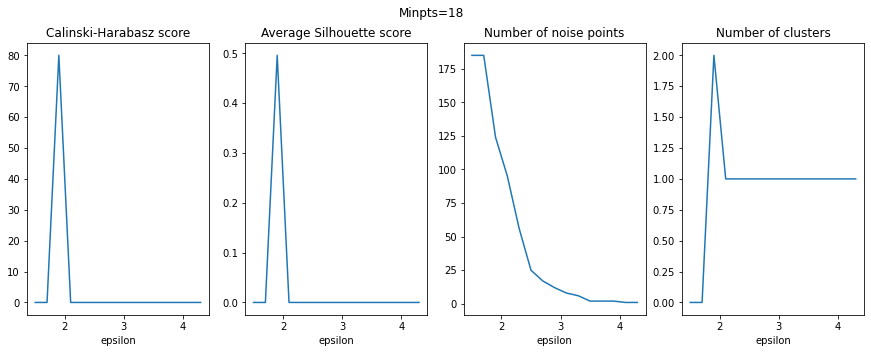

In [44]:
for minpts in [15,16,17,18]:
    calinski_harabazs_scores = []
    silhouette_scores = []
    num_clusters = []
    num_noise_points = []


    num_clusters_p = []
    n_noise_points_p = []
    silhouette_scores_p = []
    calinski_harabazs_scores_p = []

    for eps in np.arange(1.5, 4.5, 0.2):
        #Cluster the dataset using DBSCAN
        dst = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
        df1['predicted_cluster'] = dst.fit_predict(df_scaled)
        
        #Get the number of clusters in the clustering
        k=len(df1['predicted_cluster'].value_counts())-1
        num_clusters.append(k)
        
        #Get the number of noise points
        noise_point_num=len(df1[df1['predicted_cluster']==-1])
        num_noise_points.append(noise_point_num)
        
        #Average silhouette score of the clustering
        if k>1:
            silhouette_scores.append(silhouette_score(df_scaled[df1['predicted_cluster']!=-1],
                                                              df1[df1['predicted_cluster']!=-1]['predicted_cluster']))
        else:
            #(If there is only one cluster, then the average silhouette score is 0)
            silhouette_scores.append(0)
        #Calinski-Harabasz score of the clsutering
        if k>1:
            calinski_harabazs_scores.append(calinski_harabasz_score(df_scaled[df1['predicted_cluster']!=-1],
                                                                        df1[df1['predicted_cluster']!=-1]['predicted_cluster']))
        else:
            calinski_harabazs_scores.append(0)
        
    # Show the results of the preliminary analysis
    fig, ax = plt.subplots(1, 4, figsize=(15, 5), sharex=True)

    eps = np.arange(1.5, 4.5, 0.2)
    fig.suptitle('Minpts=%s'%minpts)
    ax[0].plot(eps, calinski_harabazs_scores)
    ax[1].plot(eps, silhouette_scores)    
    ax[2].plot(eps, num_noise_points)
    ax[3].plot(eps, num_clusters)

    ax[0].set_title('Calinski-Harabasz score')
    ax[1].set_title('Average Silhouette score')
    ax[2].set_title('Number of noise points')
    ax[3].set_title('Number of clusters')

    #ax[0].set_yticks(np.arange(5, 60, 7))
    ax[0].set_xlabel('epsilon')
    ax[1].set_xlabel('epsilon')
    ax[2].set_xlabel('epsilon')
    ax[3].set_xlabel('epsilon')
    plt.show()

The plots suggest we choose minpts within 15,16,17,18 as there are lots of object in this data, and epsilon should be between 1.5 and 2.5 with 2 clusters.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


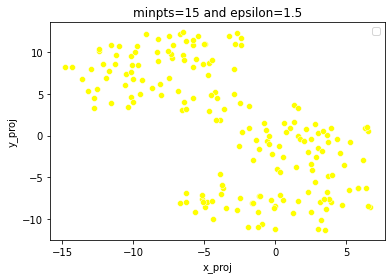

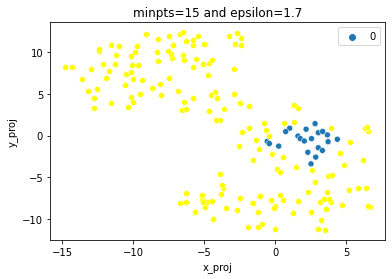

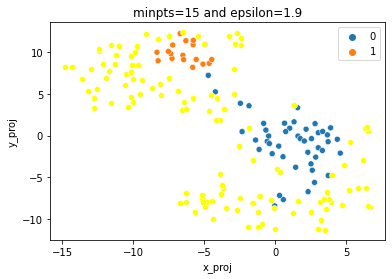

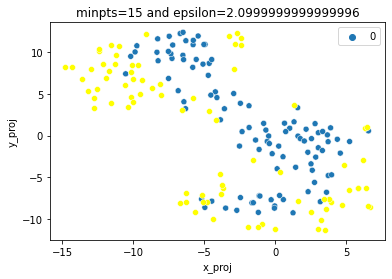

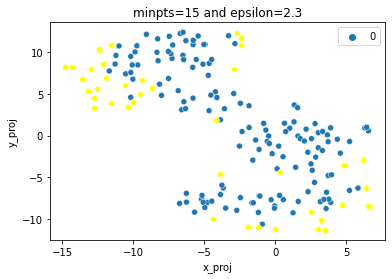

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


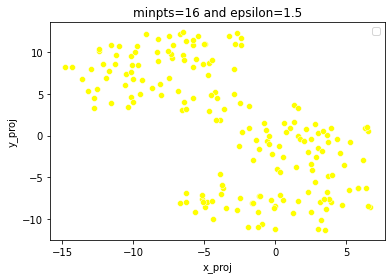

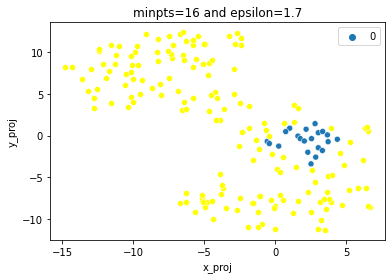

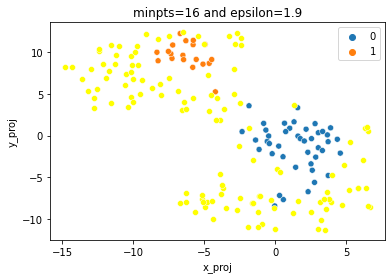

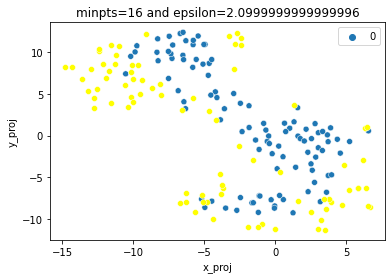

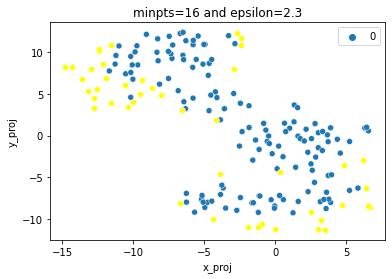

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


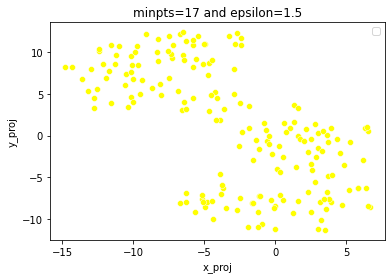

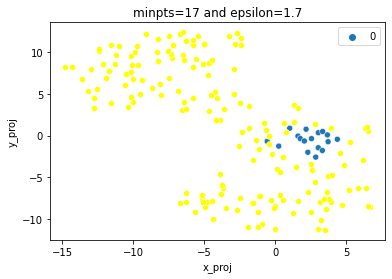

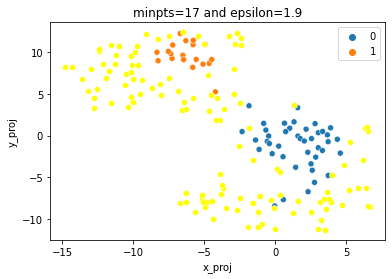

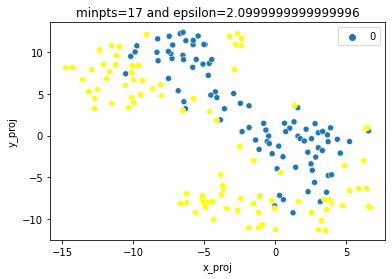

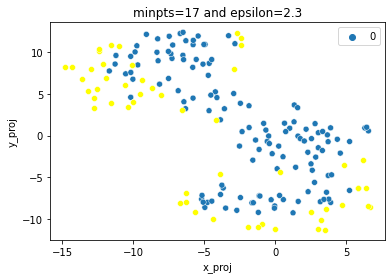

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


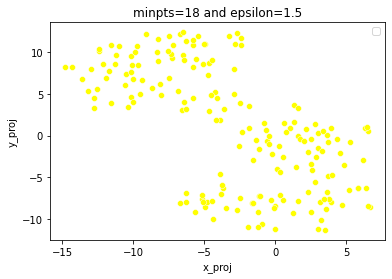

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


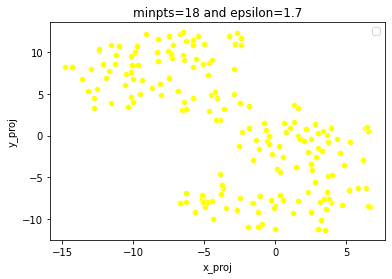

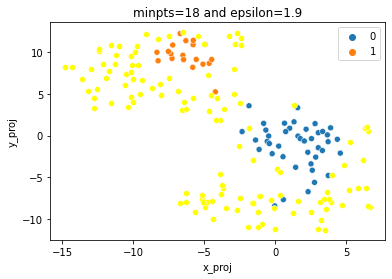

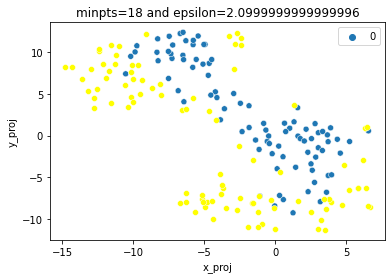

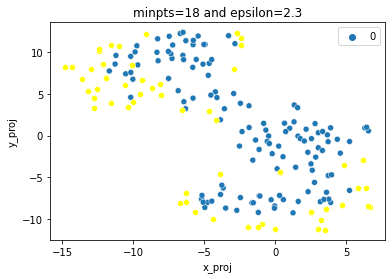

In [45]:
for minpts in [15,16,17,18]:
    for eps in np.arange(1.5, 2.5, 0.2):
        #Cluster the data with DBSCAN
        dst = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
        df_comboN['predicted_cluster'] = dst.fit_predict(df_scaled)
    
        #How many clusters
        k=len(df_comboN['predicted_cluster'].value_counts())
        
        #Plot the t-SNE plot
        sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster',
                         data=df_comboN[df_comboN['predicted_cluster']>=0])
        sns.scatterplot(x='x_proj',y='y_proj',
                        color = 'yellow', data=df_comboN[df_comboN['predicted_cluster']==-1])      
        plt.title('minpts=%s and epsilon=%s'%(minpts,eps))
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()

#### Attempt to spot outlier

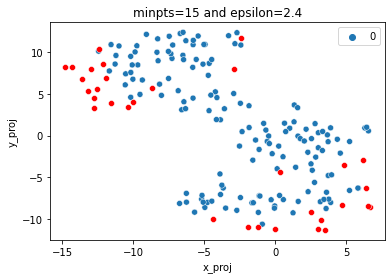

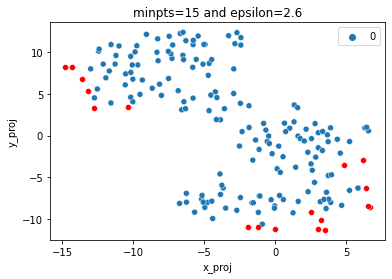

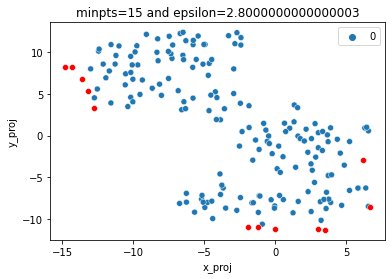

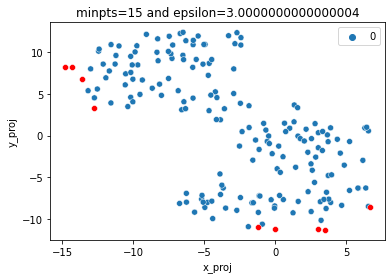

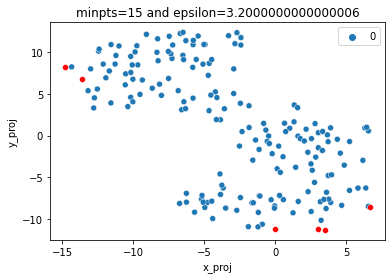

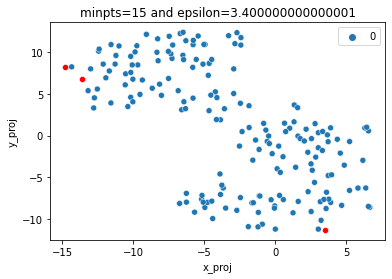

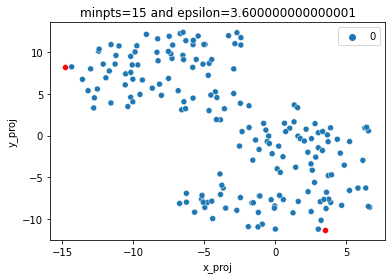

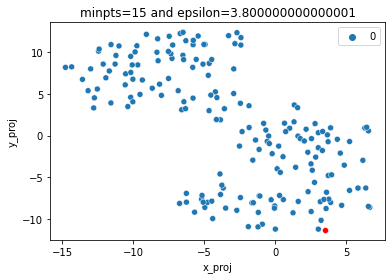

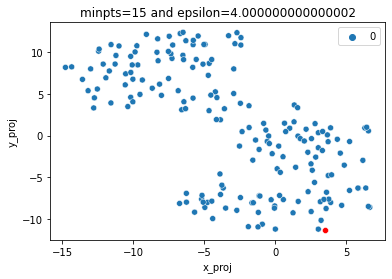

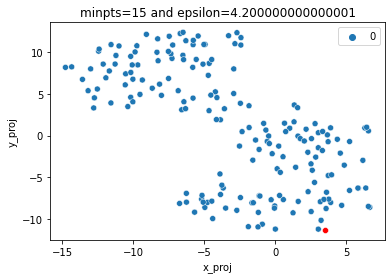

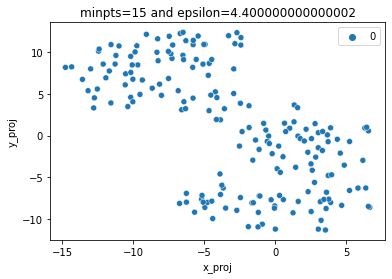

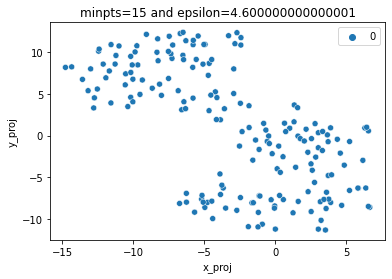

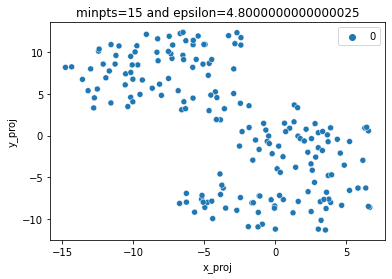

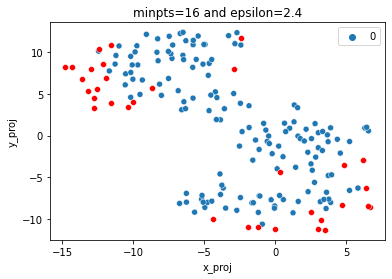

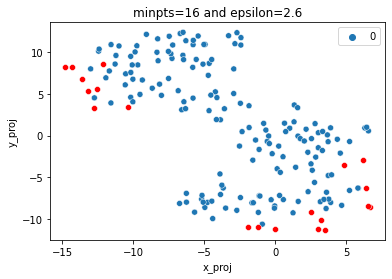

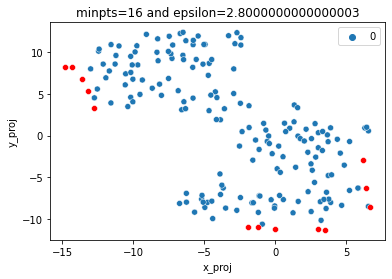

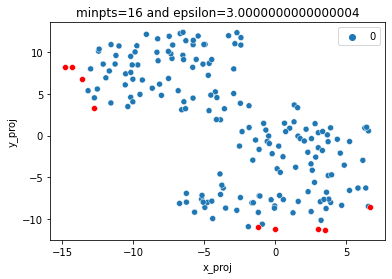

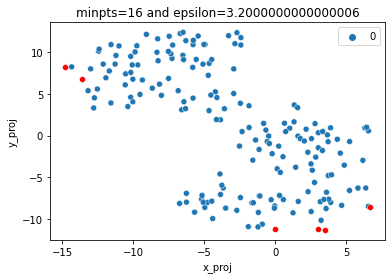

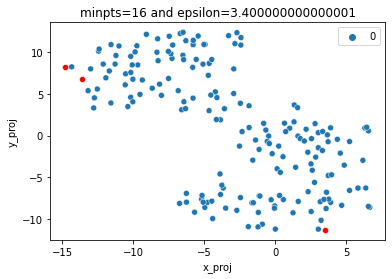

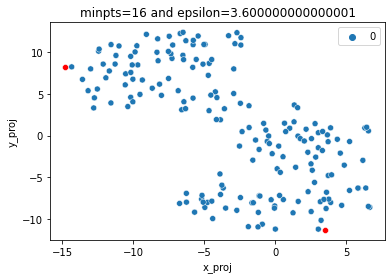

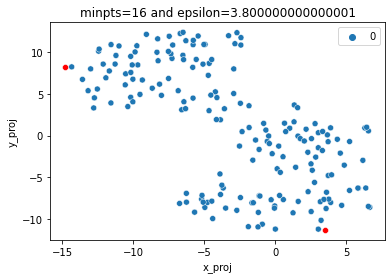

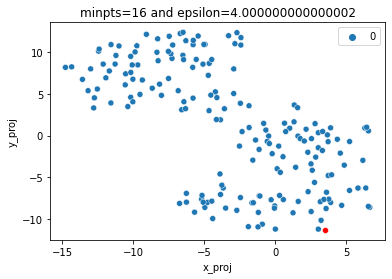

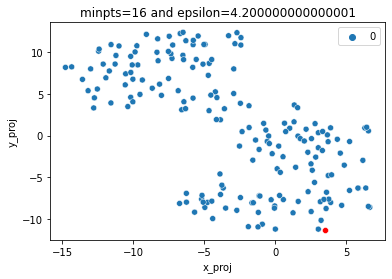

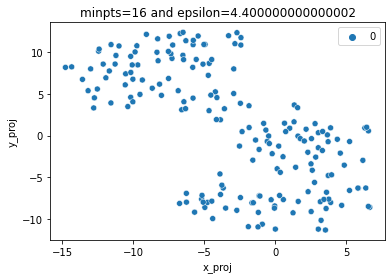

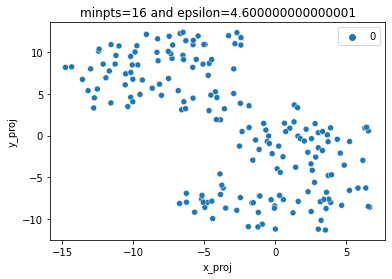

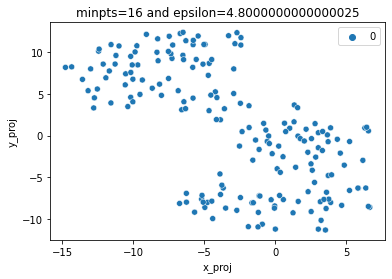

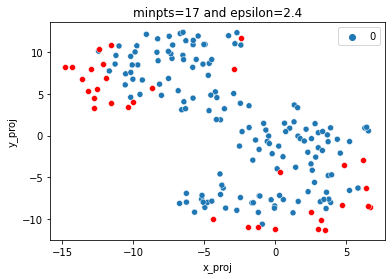

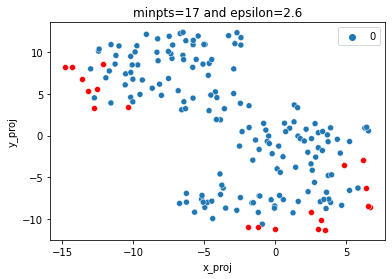

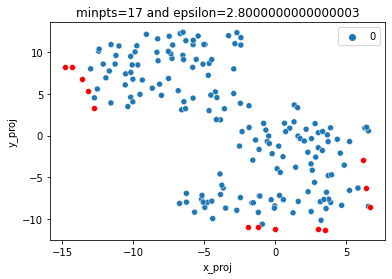

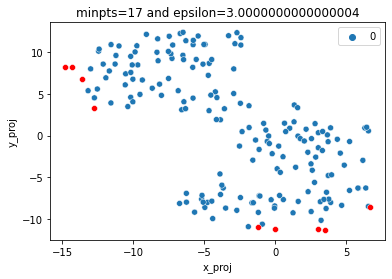

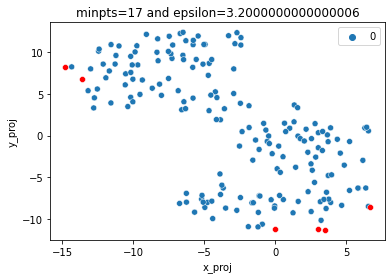

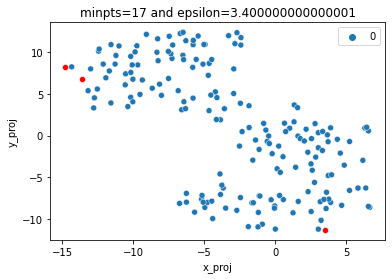

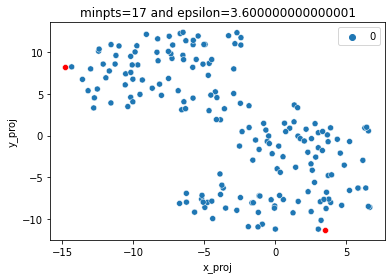

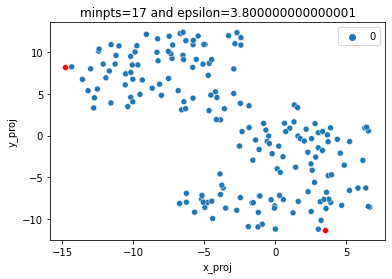

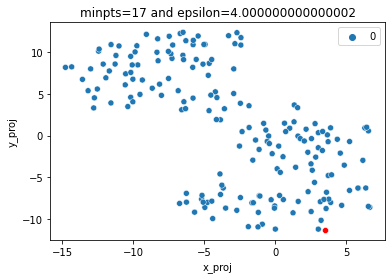

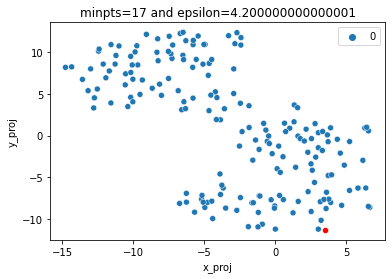

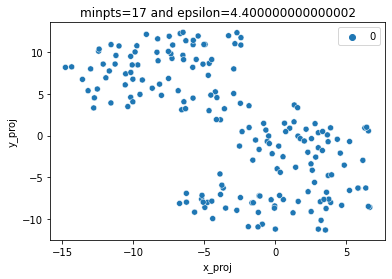

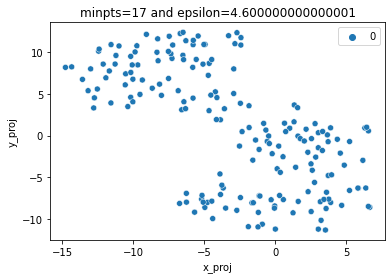

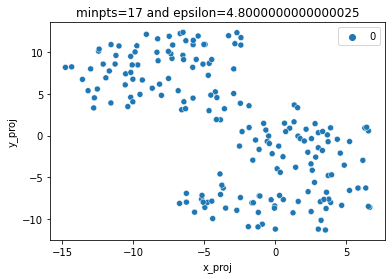

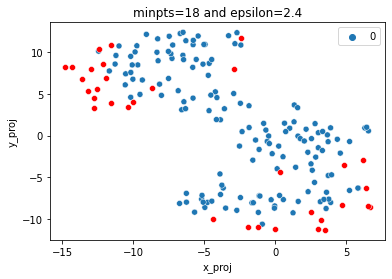

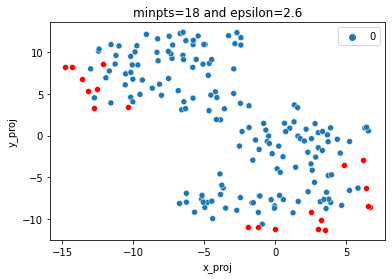

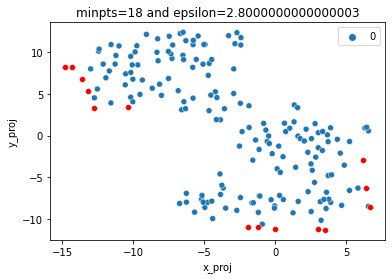

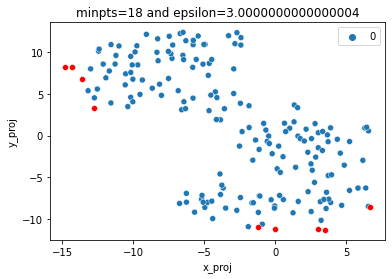

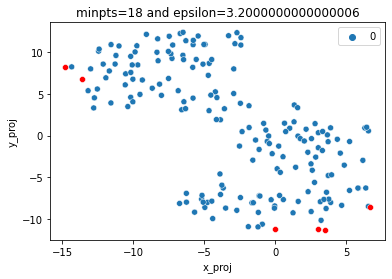

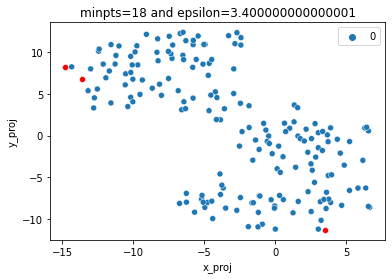

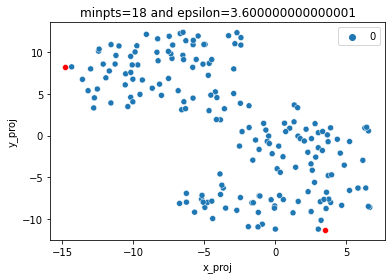

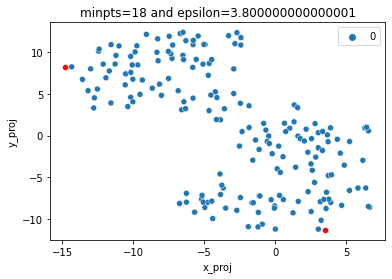

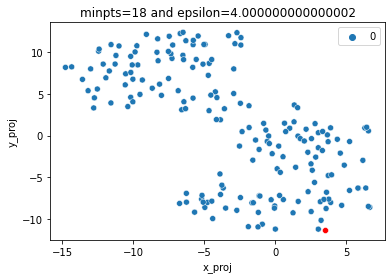

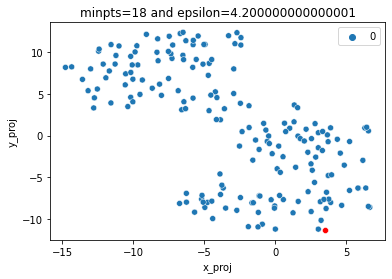

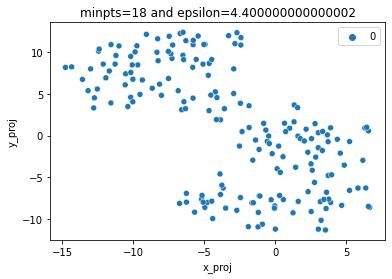

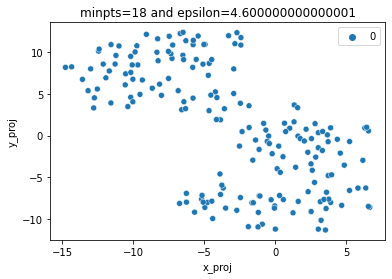

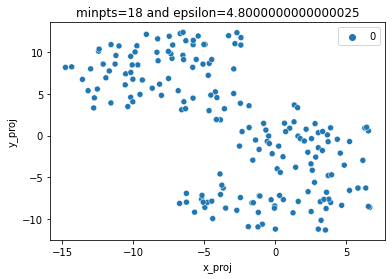

In [46]:
for minpts in [15,16,17,18]:
    for eps in np.arange(2.4, 5, 0.2):
        #Cluster the data with DBSCAN
        dst = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
        df_comboN['predicted_cluster'] = dst.fit_predict(df_scaled)
    
        #How many clusters
        k=len(df_comboN['predicted_cluster'].value_counts())
        
        #Plot the t-SNE plot
        sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster',
                         data=df_comboN[df_comboN['predicted_cluster']>=0])
        sns.scatterplot(x='x_proj',y='y_proj',
                        color = 'red', data=df_comboN[df_comboN['predicted_cluster']==-1])      
        plt.title('minpts=%s and epsilon=%s'%(minpts,eps))
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()

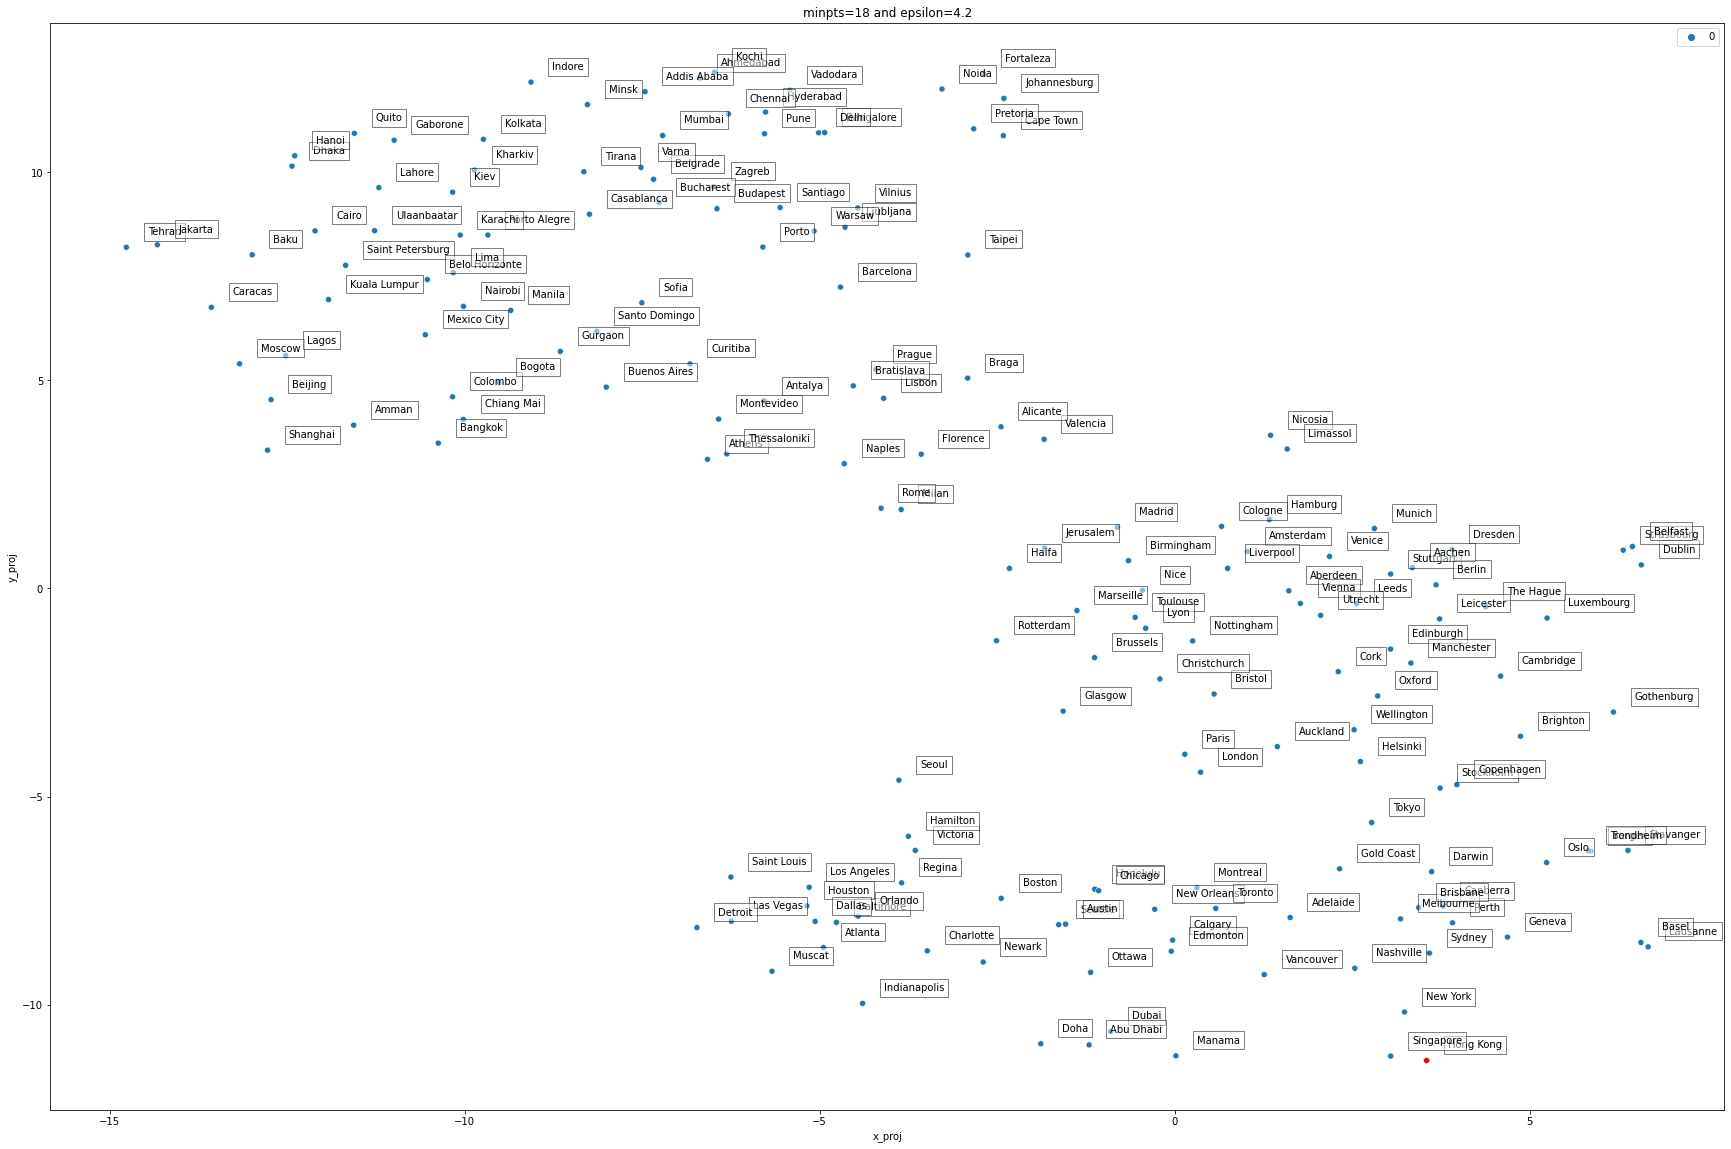

In [47]:
df_combo_out1=df_combo.copy()
df_combo_out2=df_combo.copy()
minpts = 18
eps =4.2
#Cluster the data with DBSCAN
dst = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
df_combo_out1['predicted_cluster'] = dst.fit_predict(df_scaled)
#How many clusters
k=len(df_combo_out1['predicted_cluster'].value_counts())

#Plot the t-SNE plot
plt.figure(figsize=(30,20))
sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster',
                 data=df_combo_out1[df_combo_out1['predicted_cluster']>=0])
sns.scatterplot(x='x_proj',y='y_proj',
                color = 'red', data=df_combo_out1[df_combo_out1['predicted_cluster']==-1])      
plt.title('minpts=%s and epsilon=%s'%(minpts,eps))
plt.legend(bbox_to_anchor=(1,1))
for i in range(df_combo.shape[0]):
 plt.text(x=df_combo.x_proj[i]+0.3,y=df_combo.y_proj[i]+0.3,s=df_combo_out1.City[i], 
          fontdict=dict(color='black',size=10),
          bbox=dict(facecolor='white',alpha=0.5))

plt.show()

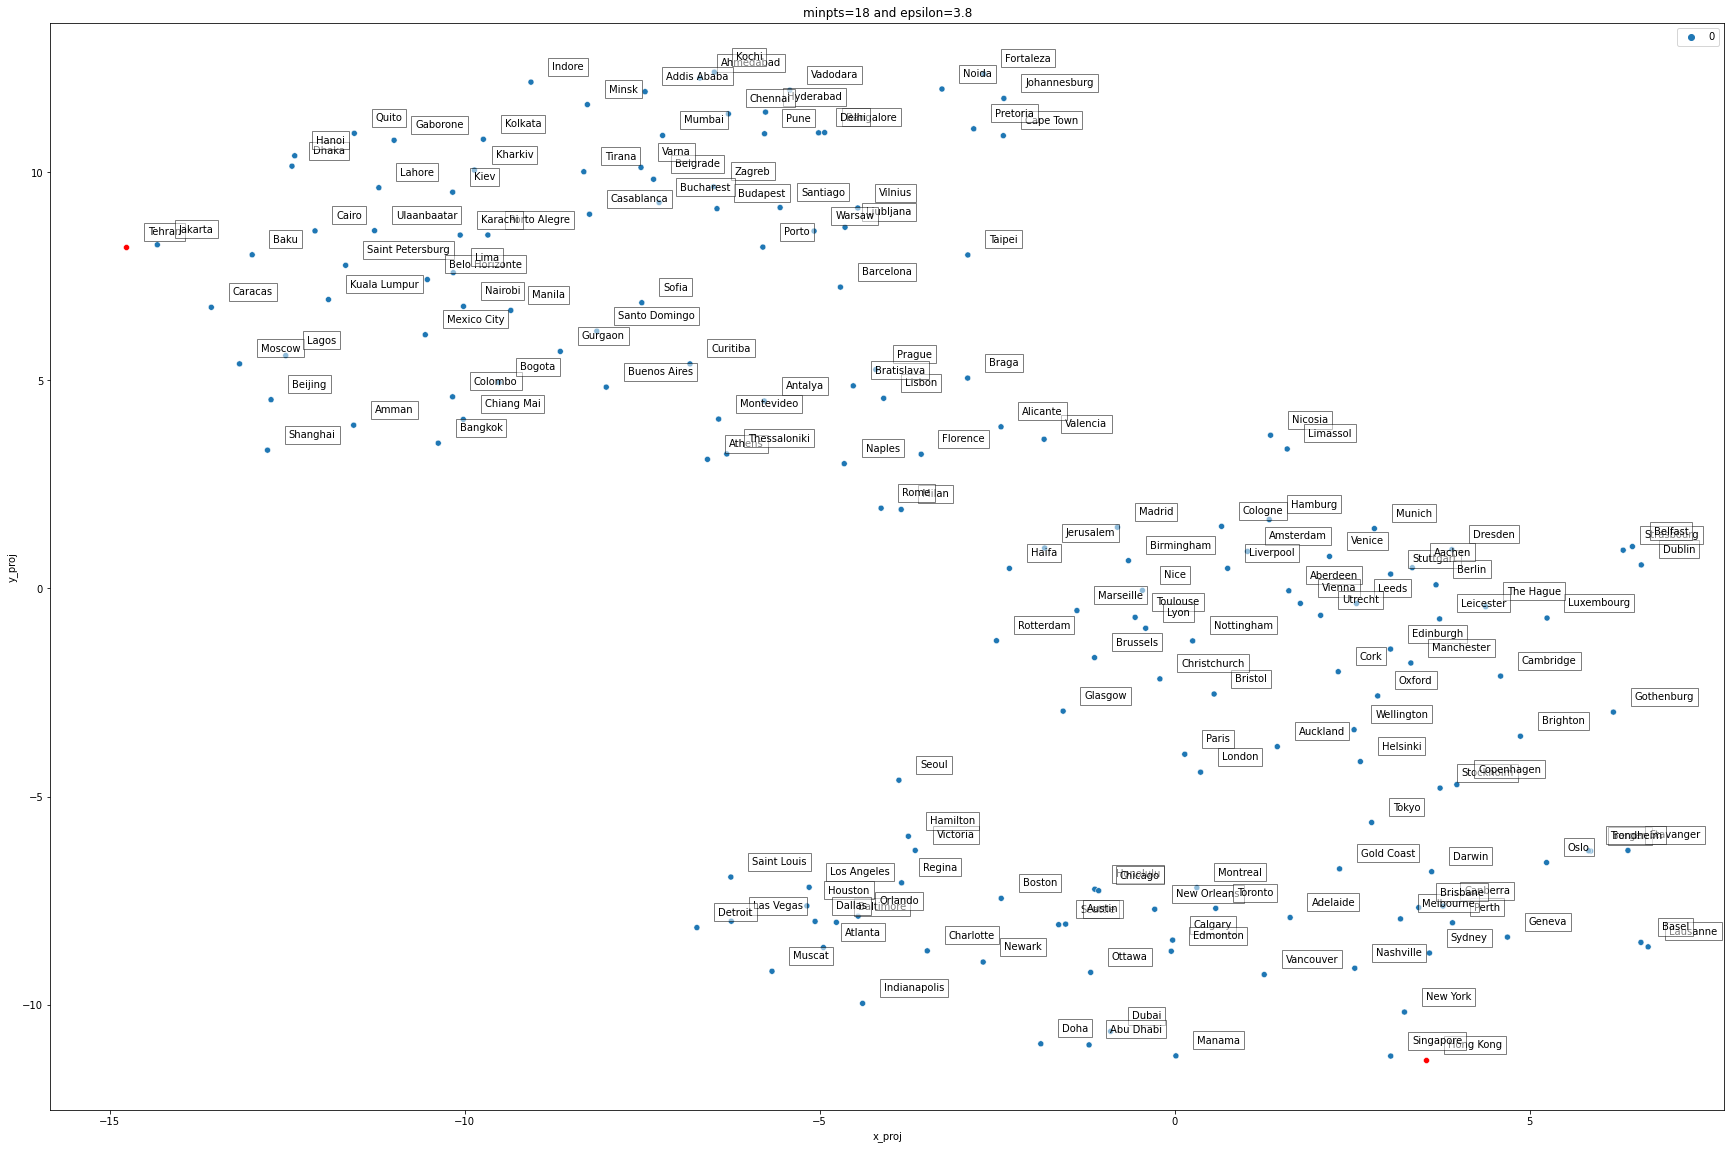

In [48]:
minpts = 18
eps =3.8
#Cluster the data with DBSCAN
dst = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
df_combo_out2['predicted_cluster'] = dst.fit_predict(df_scaled)
#How many clusters
k=len(df_combo_out2['predicted_cluster'].value_counts())

#Plot the t-SNE plot
plt.figure(figsize=(30,20))
sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster',
                 data=df_combo_out2[df_combo_out2['predicted_cluster']>=0])
sns.scatterplot(x='x_proj',y='y_proj',
                color = 'red', data=df_combo_out2[df_combo_out2['predicted_cluster']==-1])      
plt.title('minpts=%s and epsilon=%s'%(minpts,eps))
plt.legend(bbox_to_anchor=(1,1))
for i in range(df_combo.shape[0]):
 plt.text(x=df_combo.x_proj[i]+0.3,y=df_combo.y_proj[i]+0.3,s=df_combo_out1.City[i], 
          fontdict=dict(color='black',size=10),
          bbox=dict(facecolor='white',alpha=0.5))

plt.show()

 There are two outliers in the dataset when we use k=1 and they are Tehran and Hong Kong which are identified as low income, low cost of living and high income high cost of living cities respectively.

As the tsne plots shows, minpts=18 and epsilon= 1.9 seems to be the best fit parameter, it  predicted 2 well separated clusters, with the least amount of noise points.

### 8.2. Clustering Algorithm

In [49]:
minpts=18
eps =1.9
#Cluster the data with DBSCAN
dst = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean')
df_comboN['predicted_cluster'] = dst.fit_predict(df_scaled)

### 8.3. Clustering Algorithm Results Presentation

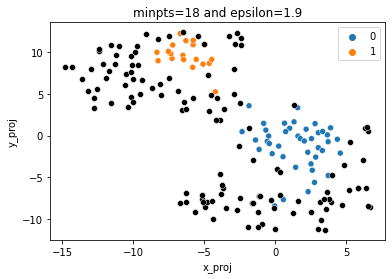

In [50]:


#Plot the t-SNE plot
sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster',
                 data=df_comboN[df_comboN['predicted_cluster']>=0])
sns.scatterplot(x='x_proj',y='y_proj',
                color = 'black', data=df_comboN[df_comboN['predicted_cluster']==-1])      
plt.title('minpts=%s and epsilon=%s'%(minpts,eps))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

We also can label the objects in the dataset whether it is higher or lower  than the median of movehub_rating.

In [51]:
import statistics
movetub_mean=statistics.mean(df['Movehub Rating'])
movetub_median=statistics.median(df['Movehub Rating'])
print(movetub_mean)
print(movetub_median)

79.6121081081081
80.68


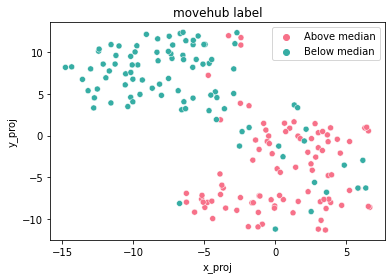

In [52]:
df_combo1=df_comboN.copy()
df_combo1['movehub_label'] = np.where(df['Movehub Rating']> 80.68, "Above median", 'Below median')
sns.scatterplot(x='x_proj',y='y_proj', hue='movehub_label',
                palette=sns.color_palette('husl', 2), data=df_combo1)
plt.title('movehub label')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

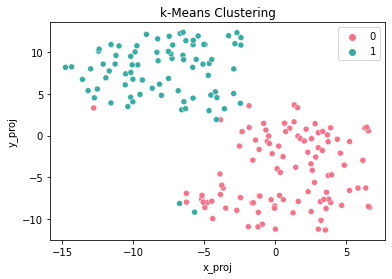

In [53]:
kmeans=KMeans(n_clusters=2, random_state=100).fit(df_scaled)
df_kmean=df_comboN.copy()
df_kmean['predicted_cluster']=kmeans.labels_

sns.scatterplot(x='x_proj',y='y_proj', hue='predicted_cluster',
                palette=sns.color_palette('husl', 2), data=df_kmean)
plt.title('k-Means Clustering')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [54]:
df1=df.copy()

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

from sklearn.preprocessing import StandardScaler

### 8.4. Assessing Clustering Separation and Cohesion

In [55]:
def show_silhouette_plots(X,cluster_labels):

    # This package allows us to use "color maps" in our visualizations
    import matplotlib.cm as cm
    
    #How many clusters in your clustering?
    n_clusters=len(np.unique(cluster_labels))    

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient fcan range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.show()
    
    return

For n_clusters = 2 The average silhouette_score is : 0.6605029817231863


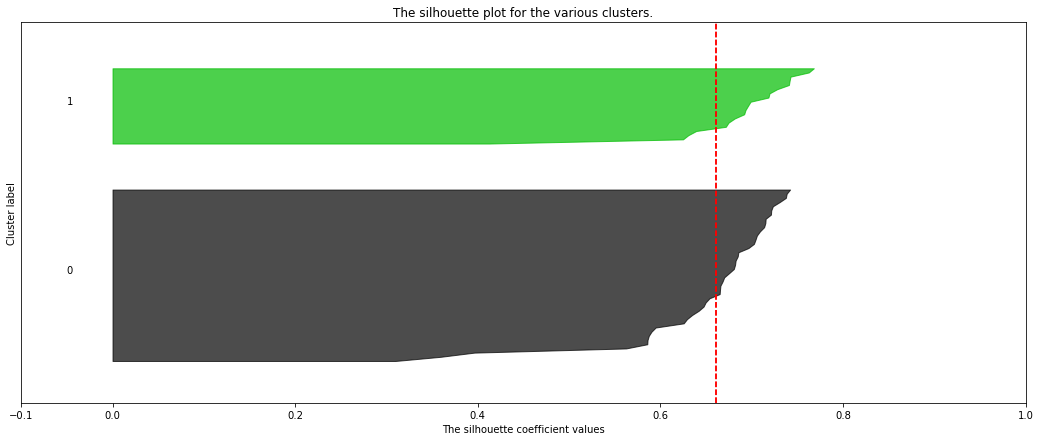

In [56]:
df_sort=df_comboN.sort_values(by=['predicted_cluster'])
df_sort=df_sort[df_sort['predicted_cluster']>=0]

cluster_labels = df_sort['predicted_cluster']
show_silhouette_plots(df_sort, cluster_labels)

In [57]:
df_sort=df_sort.drop(["predicted_cluster",'label'],axis=1)
df_sort

Cappuccino    Cinema      Wine  Gasoline  Avg Rent  \
29     0.752160  0.670028  0.747702 -0.786425  0.023096   
34     0.291748  0.864223  0.364843  0.477195  0.493363   
15     0.015501  0.644380  0.275806  1.080286  0.363278   
16     0.936325  1.325895  0.302517 -0.097178  0.311647   
23     0.370676  0.600411 -0.887611  1.453628  0.391094   
..          ...       ...       ...       ...       ...   
123   -1.707755 -0.806589 -1.077556  1.022849 -0.745901   
124   -0.418602 -0.465831 -0.549270  0.477195 -0.553470   
127   -0.444911 -0.410870 -0.869803  0.218727 -0.818724   
167   -1.734064 -1.704284 -0.656115 -0.413083 -1.183150   
157   -1.497281 -1.260932 -0.299967 -0.355645 -0.736047   

     Avg Disposable Income  Purchase Power  Health Care  Pollution  \
29                0.921407        0.901564     0.626602  -0.863965   
34                0.831388        0.169300     0.393086  -0.612980   
15                1.470379        0.451773     1.039282   0.435366   
16                1.423796        0.518208     1.089609  -0.592901   
23                1.092666        1.117109     0.050193  -0.335738   
..                     ...             ...          ...        ...   
123              -0.801907       -0.703708    -0.300753   0.839259   
124              -0.802601       -0.482749    -0.178627   1.554374   
127              -0.855697       -0.768667     0.007918   1.796092   
167              -1.201559       -0.623494     0.100519   1.241994   
157              -1.161720       -0.824276    -0.508771   0.949306   

     Quality of Life  Crime Rating    x_proj     y_proj  
29          1.291364     -0.744311 -0.028686  -8.444809  
34          0.359430      0.540031  1.445864  -3.798187  
15          0.523729     -1.071402  4.591196  -2.104063  
16          1.008027      0.086662  2.322825  -6.733579  
23          0.948282     -0.730143  4.380807  -0.437203  
..               ...           ...       ...        ...  
123        -0.004020     -0.252750 -5.801060   8.199081  
124        -0.326734     -0.590313 -5.080110   8.584001  
127        -0.901102      0.044158 -5.558050   9.149134  
167        -0.685658     -0.517010 -6.286504  11.397768  
157        -1.475923     -0.430155 -7.213269  10.879491  

[61 rows x 13 columns]

The average silhouette_score is : 0.6605029817231863. There isn't object that have poor cohesion with their assigned cluster, because the DBSCAN dropped lots of outlier, in fact, DBSCAN might drop too many objects.

### 8.5. Additional Analysis

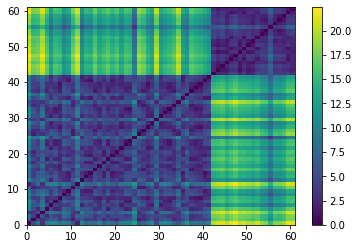

In [58]:
dist_mat = squareform(pdist(df_sort))

#Then visualize the distance matrix with a heat map.
plt.pcolormesh(dist_mat)
plt.colorbar()
N = len(df_sort)
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

#### Rand score

In [59]:
from sklearn.metrics import adjusted_rand_score
df_AA=df_comboN.copy()
df_AA['movehub_label']=df_combo1['movehub_label']
df_AA=df_AA[df_AA['predicted_cluster']>=0]
adjusted_rand_score(df_AA['movehub_label'], df_AA['predicted_cluster'])

0.5865963855421686

#### Homogeneity Score

In [60]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df_AA['movehub_label'], df_AA['predicted_cluster'])

0.5452771412636249

#### Completeness Score

In [61]:
from sklearn.metrics import completeness_score
completeness_score(df_AA['movehub_label'], df_AA['predicted_cluster'])

0.5997340717749711

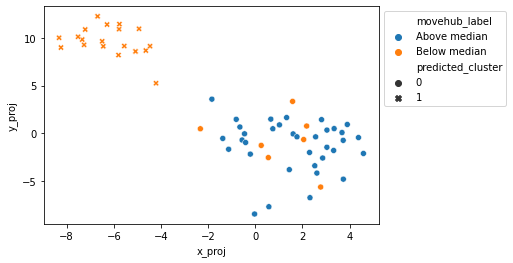

In [62]:
sns.scatterplot(x='x_proj', y='y_proj', hue='movehub_label', style='predicted_cluster', data=df_AA)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

The Rand score, Homogeneity score, and the completeness score suggests the clusters are well fitted.

### 8.6. Describing Each of the Clusters

In [63]:
df_dbscan=df_comboN[df_comboN['predicted_cluster']>=0]
df_dbscan.head()

Cappuccino    Cinema      Wine  Gasoline  Avg Rent  Avg Disposable Income  \
15    0.015501  0.644380  0.275806  1.080286  0.363278               1.470379   
16    0.936325  1.325895  0.302517 -0.097178  0.311647               1.423796   
23    0.370676  0.600411 -0.887611  1.453628  0.391094               1.092666   
29    0.752160  0.670028  0.747702 -0.786425  0.023096               0.921407   
34    0.291748  0.864223  0.364843  0.477195  0.493363               0.831388   

    Purchase Power  Health Care  Pollution  Quality of Life  Crime Rating  \
15        0.451773     1.039282   0.435366         0.523729     -1.071402   
16        0.518208     1.089609  -0.592901         1.008027      0.086662   
23        1.117109     0.050193  -0.335738         0.948282     -0.730143   
29        0.901564     0.626602  -0.863965         1.291364     -0.744311   
34        0.169300     0.393086  -0.612980         0.359430      0.540031   

      x_proj    y_proj  label  predicted_cluster  
15  4.591196 -2.104063  82.15                  0  
16  2.322825 -6.733579  82.03                  0  
23  4.380807 -0.437203  83.23                  0  
29 -0.028686 -8.444809  85.77                  0  
34  1.445864 -3.798187  86.43                  0

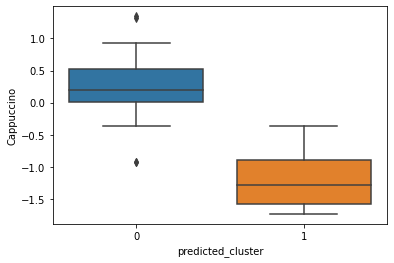

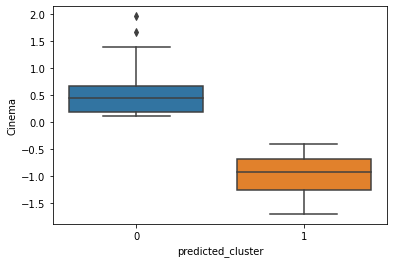

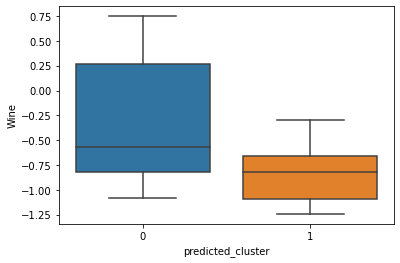

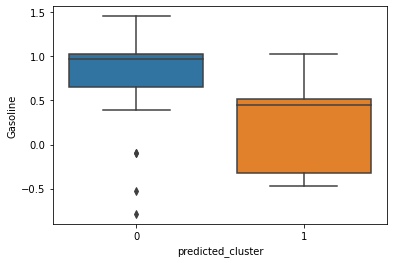

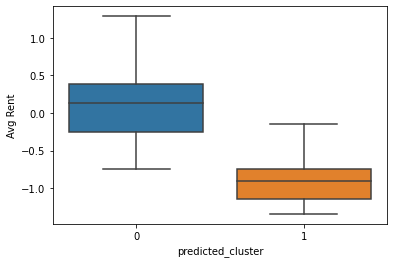

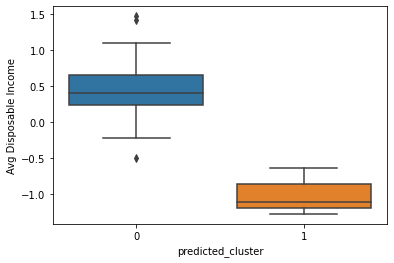

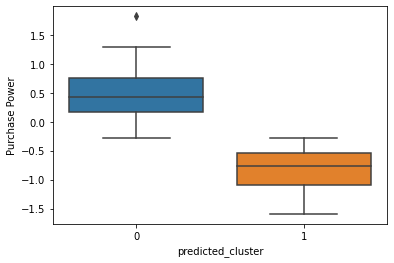

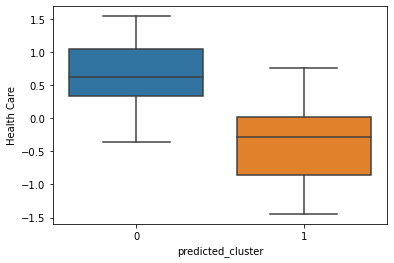

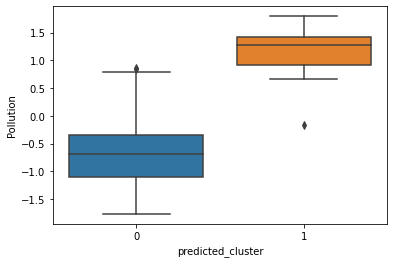

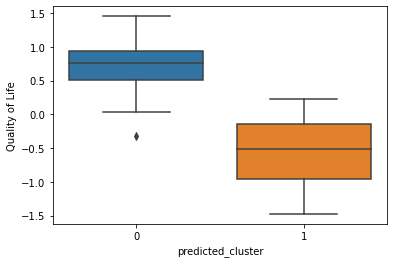

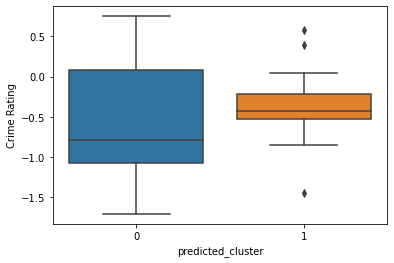

In [64]:
for col in df_dbscan.columns[0:11]:
    sns.boxplot(x="predicted_cluster", y=col, data=df_dbscan)
    plt.show()

For cluster 0, the variables Cappuccino, Cinema, Wine, Avg Rent, Avg Disposable Income,Purchase Power, Health Care, Quality of Life are higher than cluster 1, pullution in cluster 0 is lower than cluster 1. The average gasoline price are higher in cluster 0, but cluster 1 are more unified comparing to cluster 0.

#### boxplot for kmean

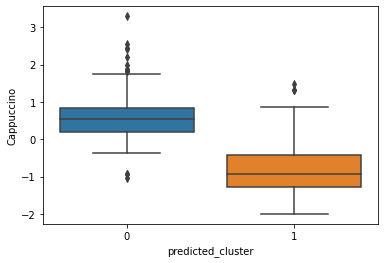

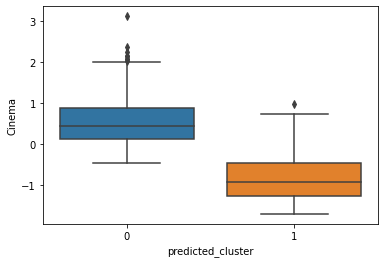

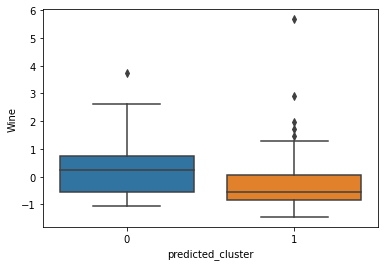

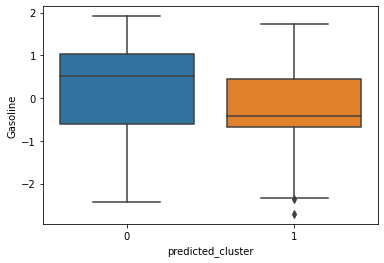

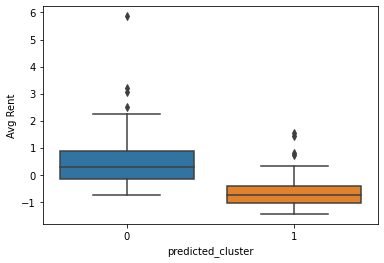

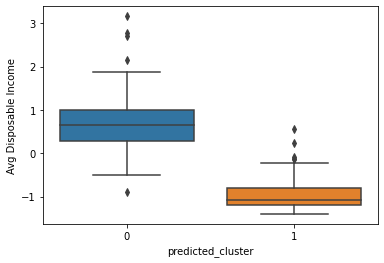

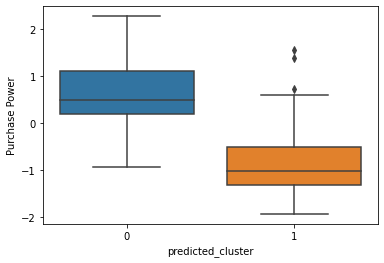

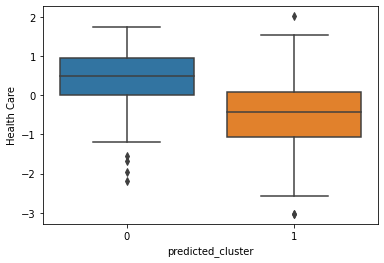

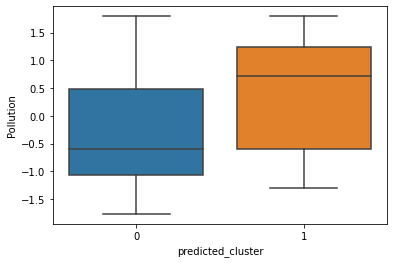

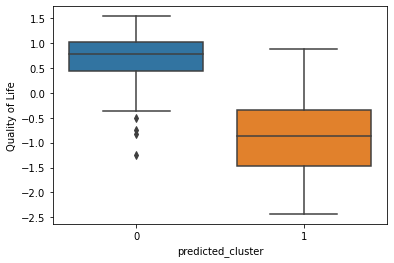

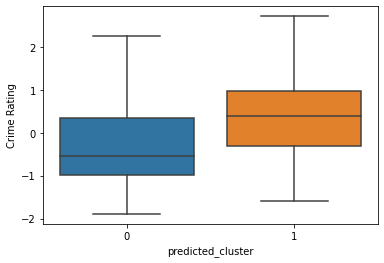

In [65]:
for col in df_kmean.columns[0:11]:
    sns.boxplot(x="predicted_cluster", y=col, data=df_kmean)
    plt.show()

## 9. Analysis Summary and Conclusion

### 9.1. Algorithm Comparison Summary

#### 9.1.1. Comparing Algorithm Performance

While the HAC as seen above does succeed in identifying some substructures in our data as we originally hypothesized, it seems like DBSCAN was not too useful in isolating outliars. We can conclude that there isn't too much noise in the underlying dataset. The overarching results of HAC and DBSCAN can be compared by looking at the HAC with k=2 and the DBSCAN minpts=18 eps=2.3

We note that while these methods are slightly comparable in that they both return a a 2-clustering, while HAC returns a proper 2-partition on our original dataset, DBSCAN does not.

#### 9.1.2. Comparing Algorithm Results

HAC: Cluster 0, we have higher values for everything except pollution and crime rating which are both lower

DBSCAN: For cluster 0, the variables Cappuccino, Cinema, Wine, Gasoline, Avg Rent, Avg Disposable Income,Purchase Power, Health Care, Quality of Life are higher than cluster 1, pullution in cluster 0 is lower than cluster 1. But the average crime rate are not significant different between two clusters, crime rate in cluster 0 are various, and crime rate in cluster 1 are similar to other objects in cluster.

While the HAC and DBSCAN results line up nicely on the TSNE plots (see previous sections) there is a main difference in that the DBSCAN detected cluster had average crime rate the same in both clusters. This suggests that the cities with very high or low crime rates are being treated as outliars.

For HAC we also had a 5-cluster which was able to identiy subclusters. 

Within cluster 0 we have an ultra-well off but much higher average prices cluster (2), some median level ones (0 and 1), and then within cluster 1 we have cluster (3) and (4) which share low incomes, high pollution and crime rates.

### 9.2. Conclusion and Insights Summary

Ultimately we learned that (1) DBSCAN is not a very viable algorithm for discovery too many insights from this dataset. From this we learned that the points were relatively homogeneous without large outliars. (2) HAC successfully was able to break the dataset up into clusters that closely resemble the preassigned class labels. This means that wards similarity between the points is a good metric to assess whether or not two cities are similar. We further learned that within the two main clusters we could break affluent cities into three categories while we could break not-so-affluent cities into two categories. These categories revealed that different cities could potentially have different specializations. For example, one cluster showed slightly lower income and standards of living but a large purchasing power, suggesting that cluster might contain cities that are trade-oriented.

## 10. Group Contribution Report

Justin Wang: 1-6,9, Sarah Yang:7, Congfei Yin:8